# Comparison of  filters on image classifiers

Das Benötigte Datenset kann unter https://www.kaggle.com/thedagger/pokemon-generation-one gefunden werden. Dieses sollte unter ./dataset abgespeichert werden. Zudem sollten alle SVG Dateien entfert werden.

# Imports and global variables

Start by importing the necassary libraries

In [1]:
print('Importing...')
from PIL import Image, ImageFilter

import matplotlib as npl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

import numpy as np

import os

import pandas as pd
import time

import random

from sklearn import datasets
from sklearn.utils import Bunch
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.dummy import DummyClassifier

print('Finished Importing...')

Importing...
Finished Importing...


Define the Filters and the Classifiers used in the comparison. Also define what parameters the classifiers use.
It is always the structure (\<CLASSIFIER OR IMAGE FILTER>, \<NAME>)

In [2]:
filters = [
    (None, "none"),
    (ImageFilter.BLUR, "Blur"),
    (ImageFilter.CONTOUR, "Contour"),
    (ImageFilter.DETAIL, "Detail"),
    (ImageFilter.EMBOSS, "Emboxx"),
    (ImageFilter.FIND_EDGES, "Find Edges"),
    (ImageFilter.SHARPEN, "Sharpen"),
    (ImageFilter.SMOOTH, "Smooth"),
    (ImageFilter.SMOOTH_MORE, "Smooth More"),
    (ImageFilter.EDGE_ENHANCE, "Edge Enhance"),
    (ImageFilter.EDGE_ENHANCE_MORE, "Edge Enhance More"),
]

classifiers = [
    (KNeighborsClassifier(3), "Nearest Neighbor"),
    (SVC(kernel="linear", C=0.025, max_iter=1000), "SVM"),
    (SVC(gamma=2, C=1, max_iter=1000), "RBF SVM"),
    # takes too long: (GaussianProcessClassifier(1.0 * RBF(1.0)), "Gaussian Process"),
    (DecisionTreeClassifier(max_depth=5), "Decision Tree"),
    (RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), "Random Forest"),
    (AdaBoostClassifier(), "AdaBoost"),
    (GaussianNB(), "Naives Bayes"),
    (QuadraticDiscriminantAnalysis(), "QDA"),
    (MLPClassifier(hidden_layer_sizes=(512, 256)), "Neural Net"),
    # is as bad as dummy classifier (MLPClassifier(alpha=1, max_iter=1000), "Neural Net Standard"),
    (DummyClassifier(strategy="most_frequent"), "Dummy")
]

Define some parameters for preprocessing the data. It will load the data from dataset_directory and will resize the images to resize_resolution. It will only use as many classes as number_of_classes is, here it will for example take the 20 classes with the most images.

In [3]:
dataset_directory = './dataset'
resize_resolution = 32,32
number_of_classes = 20

# Filter Examples

In [104]:
def print_filter_examples():
    image_paths = [f.path for f in os.scandir(f'example_images')]
    nrows = len(image_paths)
    ncols = len(filters) + 1
    fig = plt.figure(figsize=(25,25))
    grid = ImageGrid(fig, 111,
                    nrows_ncols=(nrows,ncols),
                    axes_pad=0.1
                    )
    images = []
    for image_path in image_paths:
        img = Image.open(image_path)
        img = img.resize(resize_resolution)
        # Add color image
        images.append(img)
        # Add grayscaled image
        img = img.convert('L')
        images.append(img)
        for image_filter in filters:
            if image_filter[0] is not None:
                filtered_image = img.filter(image_filter[0])
                images.append(filtered_image)
    for index, (ax, im) in enumerate(zip(grid, images)):
        if index < ncols:
            if index == 0:
                ax.set_title('Normal')
            elif index == 1:
                ax.set_title('None')
            else:
                ax.set_title(filters[index - 1][1])
        ax.imshow(im, cmap='gray')
        ax.axis('off')
    plt.show()
        

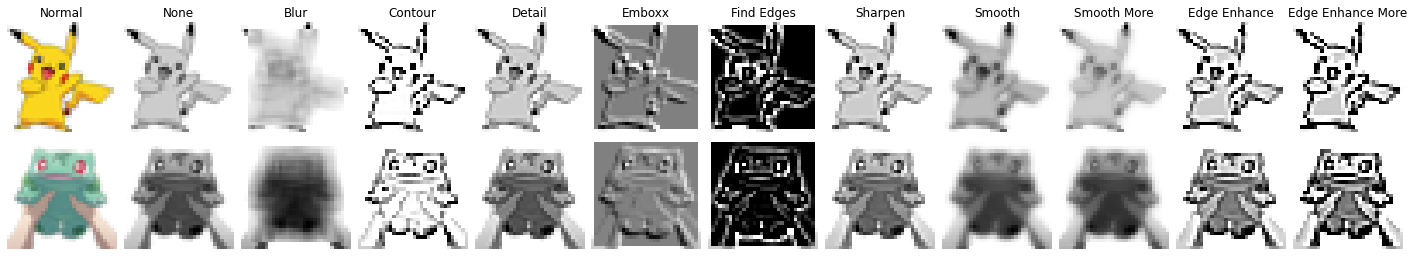

In [108]:
print_filter_examples()

# Helper functions

This function loads the dataset, resizes it, grayscales it and applies the filter. Lastly it transforms the label names into numbers.

In [4]:
def load_pokemon_dataset(image_filter):
    print(f'Loading from dataset {dataset_directory}')
    print(f'Applying filter "{image_filter[1]}" to pictures')
    data = []
    target = []
    labels = [f.name for f in os.scandir(dataset_directory) if f.is_dir()]
    labels.sort(reverse=True, key=lambda label:len(
        [f.name for f in os.scandir(f'{dataset_directory}/{label}')]
    ))
    labels = labels[0:number_of_classes]
    for label in labels:
        images = [f.path for f in os.scandir(f'{dataset_directory}/{label}')]
        print(f'\t Loading images for {label}... Found {len(images)}')
        for image_path in images:
            img = Image.open(image_path)
            img = img.resize(resize_resolution)
            img = img.convert('L')
            if image_filter[0] is not None:
                img = img.filter(image_filter[0])
            img_data = np.asarray(img)
            img_data = img_data.flatten()
            data.append(img_data)
            target.append(label)
    print(f'Finished loading dataset')
    le = preprocessing.LabelEncoder()
    le.fit(target)
    target_categorical = le.transform(target)
    return Bunch(
        data=data,
        target=target_categorical,
        target_names=le.classes_
    )

This function displays some of the loaded images.

In [5]:
def display_image_data(X):
    np_x = np.array(X)
    print(f'Loaded {np_x.shape[0]} data entries with {np_x.shape[1]} features each')

    print('Displaying some example images')

    plt.figure(figsize=(50,50))
    columns = 6
    numbers_of_images = 18

    for i in range(numbers_of_images):
        rand = random.randrange(len(X))
        arr = np.array(X[rand]).reshape(resize_resolution)
        plt.subplot(numbers_of_images / columns + 1, columns, i + 1)
        plt.imshow(Image.fromarray(arr), cmap='gray', vmin=0, vmax=255)
    plt.show()

This function calculates the scores for all classifiers given a image filter. The scores it calculates are accuracy and f1 score. For each of them it uses a 10-fold-cross-validation

In [6]:
def get_scores_for_classifiers(image_filter):
    data = load_pokemon_dataset(image_filter)
    display_image_data(data.data)
    X = data.data
    y = data.target
    scores = []
    cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42)
    print(f'Training classifiers with filter: {image_filter[1]}')
    for clf in classifiers:
        name = clf[1]
        classifier = clf[0]
        start_time = time.time()

        print(f'\t Using Classifier: {name}')
        score = cross_val_score(classifier, X, y, cv=cv, n_jobs=4)
        print("\t\t Accuracy: %0.8f (+/- %0.8f)" % (score.mean(), score.std()))
        f1_score = cross_val_score(classifier, X, y, scoring="f1_weighted", cv=cv, n_jobs=4)
        print("\t\t F1-Score: %0.8f (+/- %0.8f)" % (f1_score.mean(), f1_score.std()))
        elapsed_time = time.time() - start_time
        print(f'\t\t Time it took to train: {elapsed_time}')

        scores.append([name, f1_score.mean(), f1_score.std(), score.mean(), score.std(), elapsed_time])
    return scores

Here we exectue the above function for each filter and store the results. It is to note that the displayed images are chosen randomly. Every Classifier gets the same dataset.

============== Using Filter (None, 'none') ================
Loading from dataset ./dataset
Applying filter "none" to pictures
	 Loading images for Mewtwo... Found 306


c:\programming\gitrepos\sema\venv\lib\site-packages\PIL\Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


	 Loading images for Pikachu... Found 298
	 Loading images for Charmander... Found 296
	 Loading images for Bulbasaur... Found 289
	 Loading images for Squirtle... Found 280
	 Loading images for Psyduck... Found 159
	 Loading images for Spearow... Found 130
	 Loading images for Fearow... Found 122
	 Loading images for Dratini... Found 109
	 Loading images for Aerodactyl... Found 97
	 Loading images for Rapidash... Found 83
	 Loading images for Shellder... Found 81
	 Loading images for Ninetales... Found 74
	 Loading images for Pidgey... Found 74
	 Loading images for Mankey... Found 72
	 Loading images for Lapras... Found 71
	 Loading images for Machamp... Found 71
	 Loading images for Muk... Found 71
	 Loading images for Raichu... Found 71
	 Loading images for Sandslash... Found 71
Finished loading dataset
Loaded 2825 data entries with 1024 features each
Displaying some example images


c:\programming\gitrepos\sema\venv\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


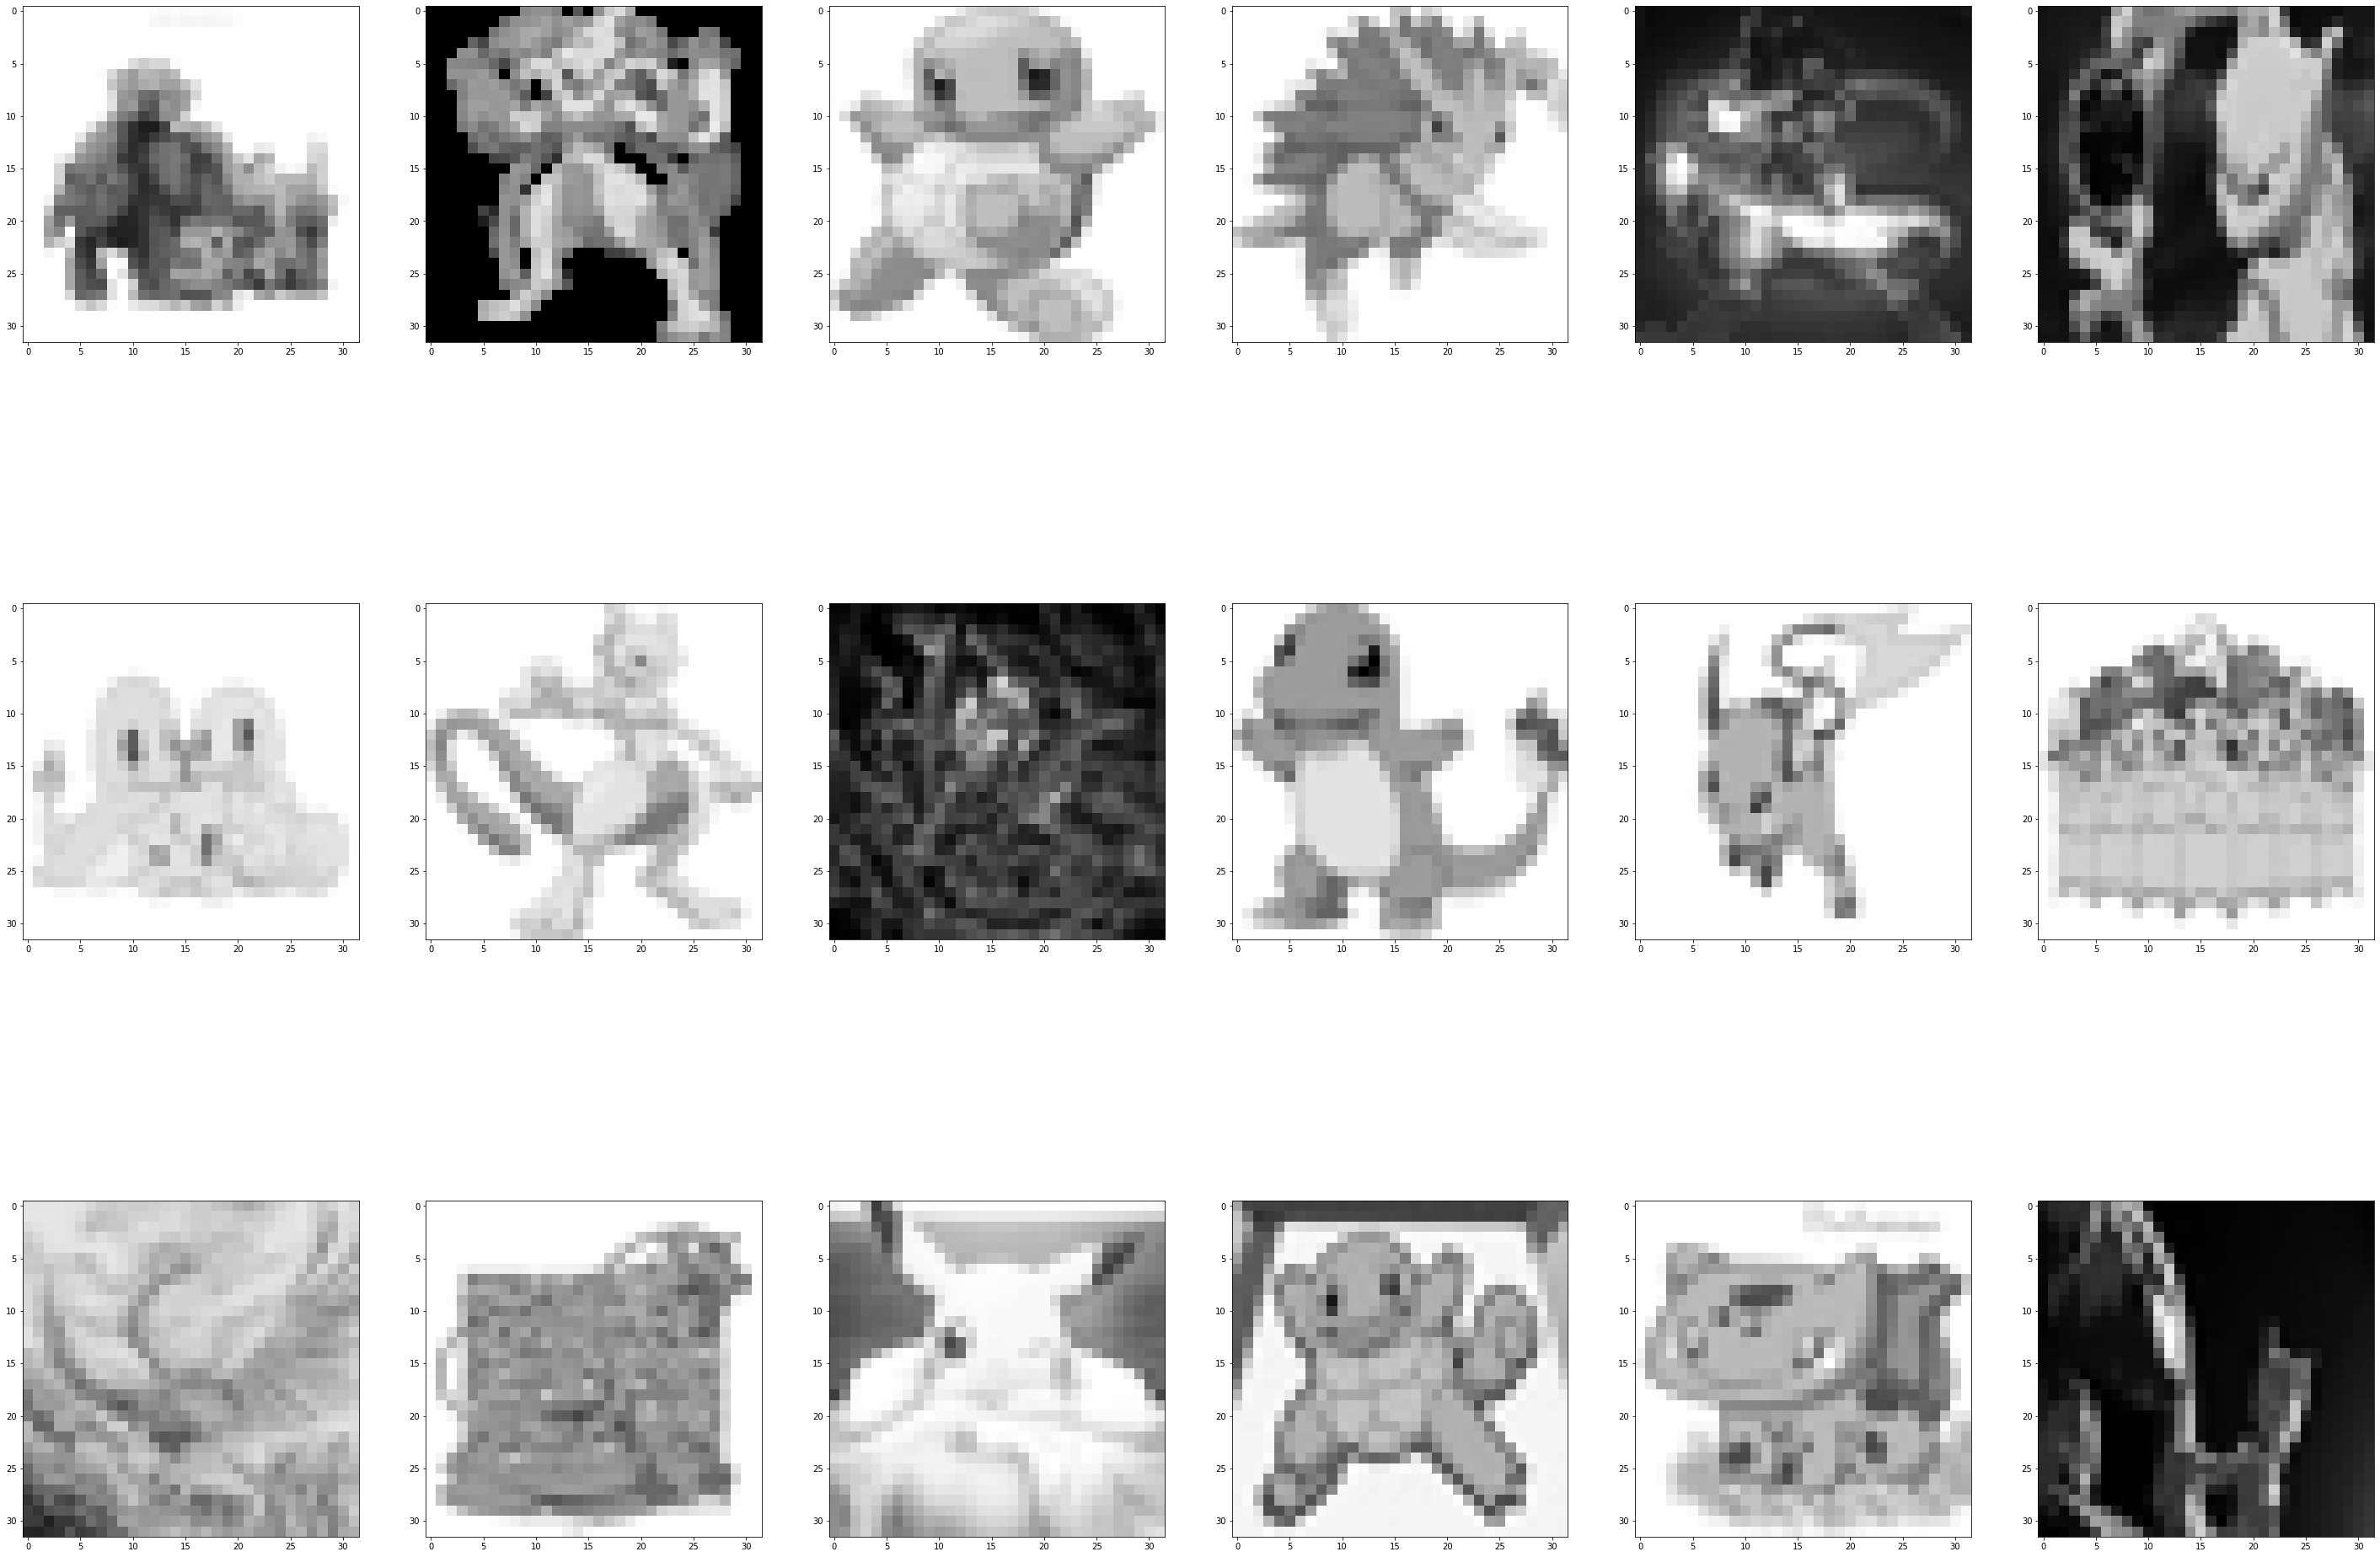

Training classifiers with filter: none
	 Using Classifier: Nearest Neighbor
		 Accuracy: 0.32932862 (+/- 0.03564529)
		 F1-Score: 0.31010078 (+/- 0.03747442)
		 Time it took to train: 14.48185420036316
	 Using Classifier: SVM
		 Accuracy: 0.42897527 (+/- 0.02696648)
		 F1-Score: 0.41976898 (+/- 0.02659252)
		 Time it took to train: 72.3182156085968
	 Using Classifier: RBF SVM
		 Accuracy: 0.26537102 (+/- 0.01622751)
		 F1-Score: 0.25674341 (+/- 0.01478813)
		 Time it took to train: 114.39511585235596
	 Using Classifier: Decision Tree
		 Accuracy: 0.23286219 (+/- 0.02766358)
		 F1-Score: 0.19279003 (+/- 0.02882285)
		 Time it took to train: 5.050065040588379
	 Using Classifier: Random Forest
		 Accuracy: 0.27809187 (+/- 0.02138028)
		 F1-Score: 0.22373409 (+/- 0.02501826)
		 Time it took to train: 2.1687355041503906
	 Using Classifier: AdaBoost
		 Accuracy: 0.19611307 (+/- 0.02514799)
		 F1-Score: 0.18149025 (+/- 0.02437359)
		 Time it took to train: 50.99107885360718
	 Using Classifier

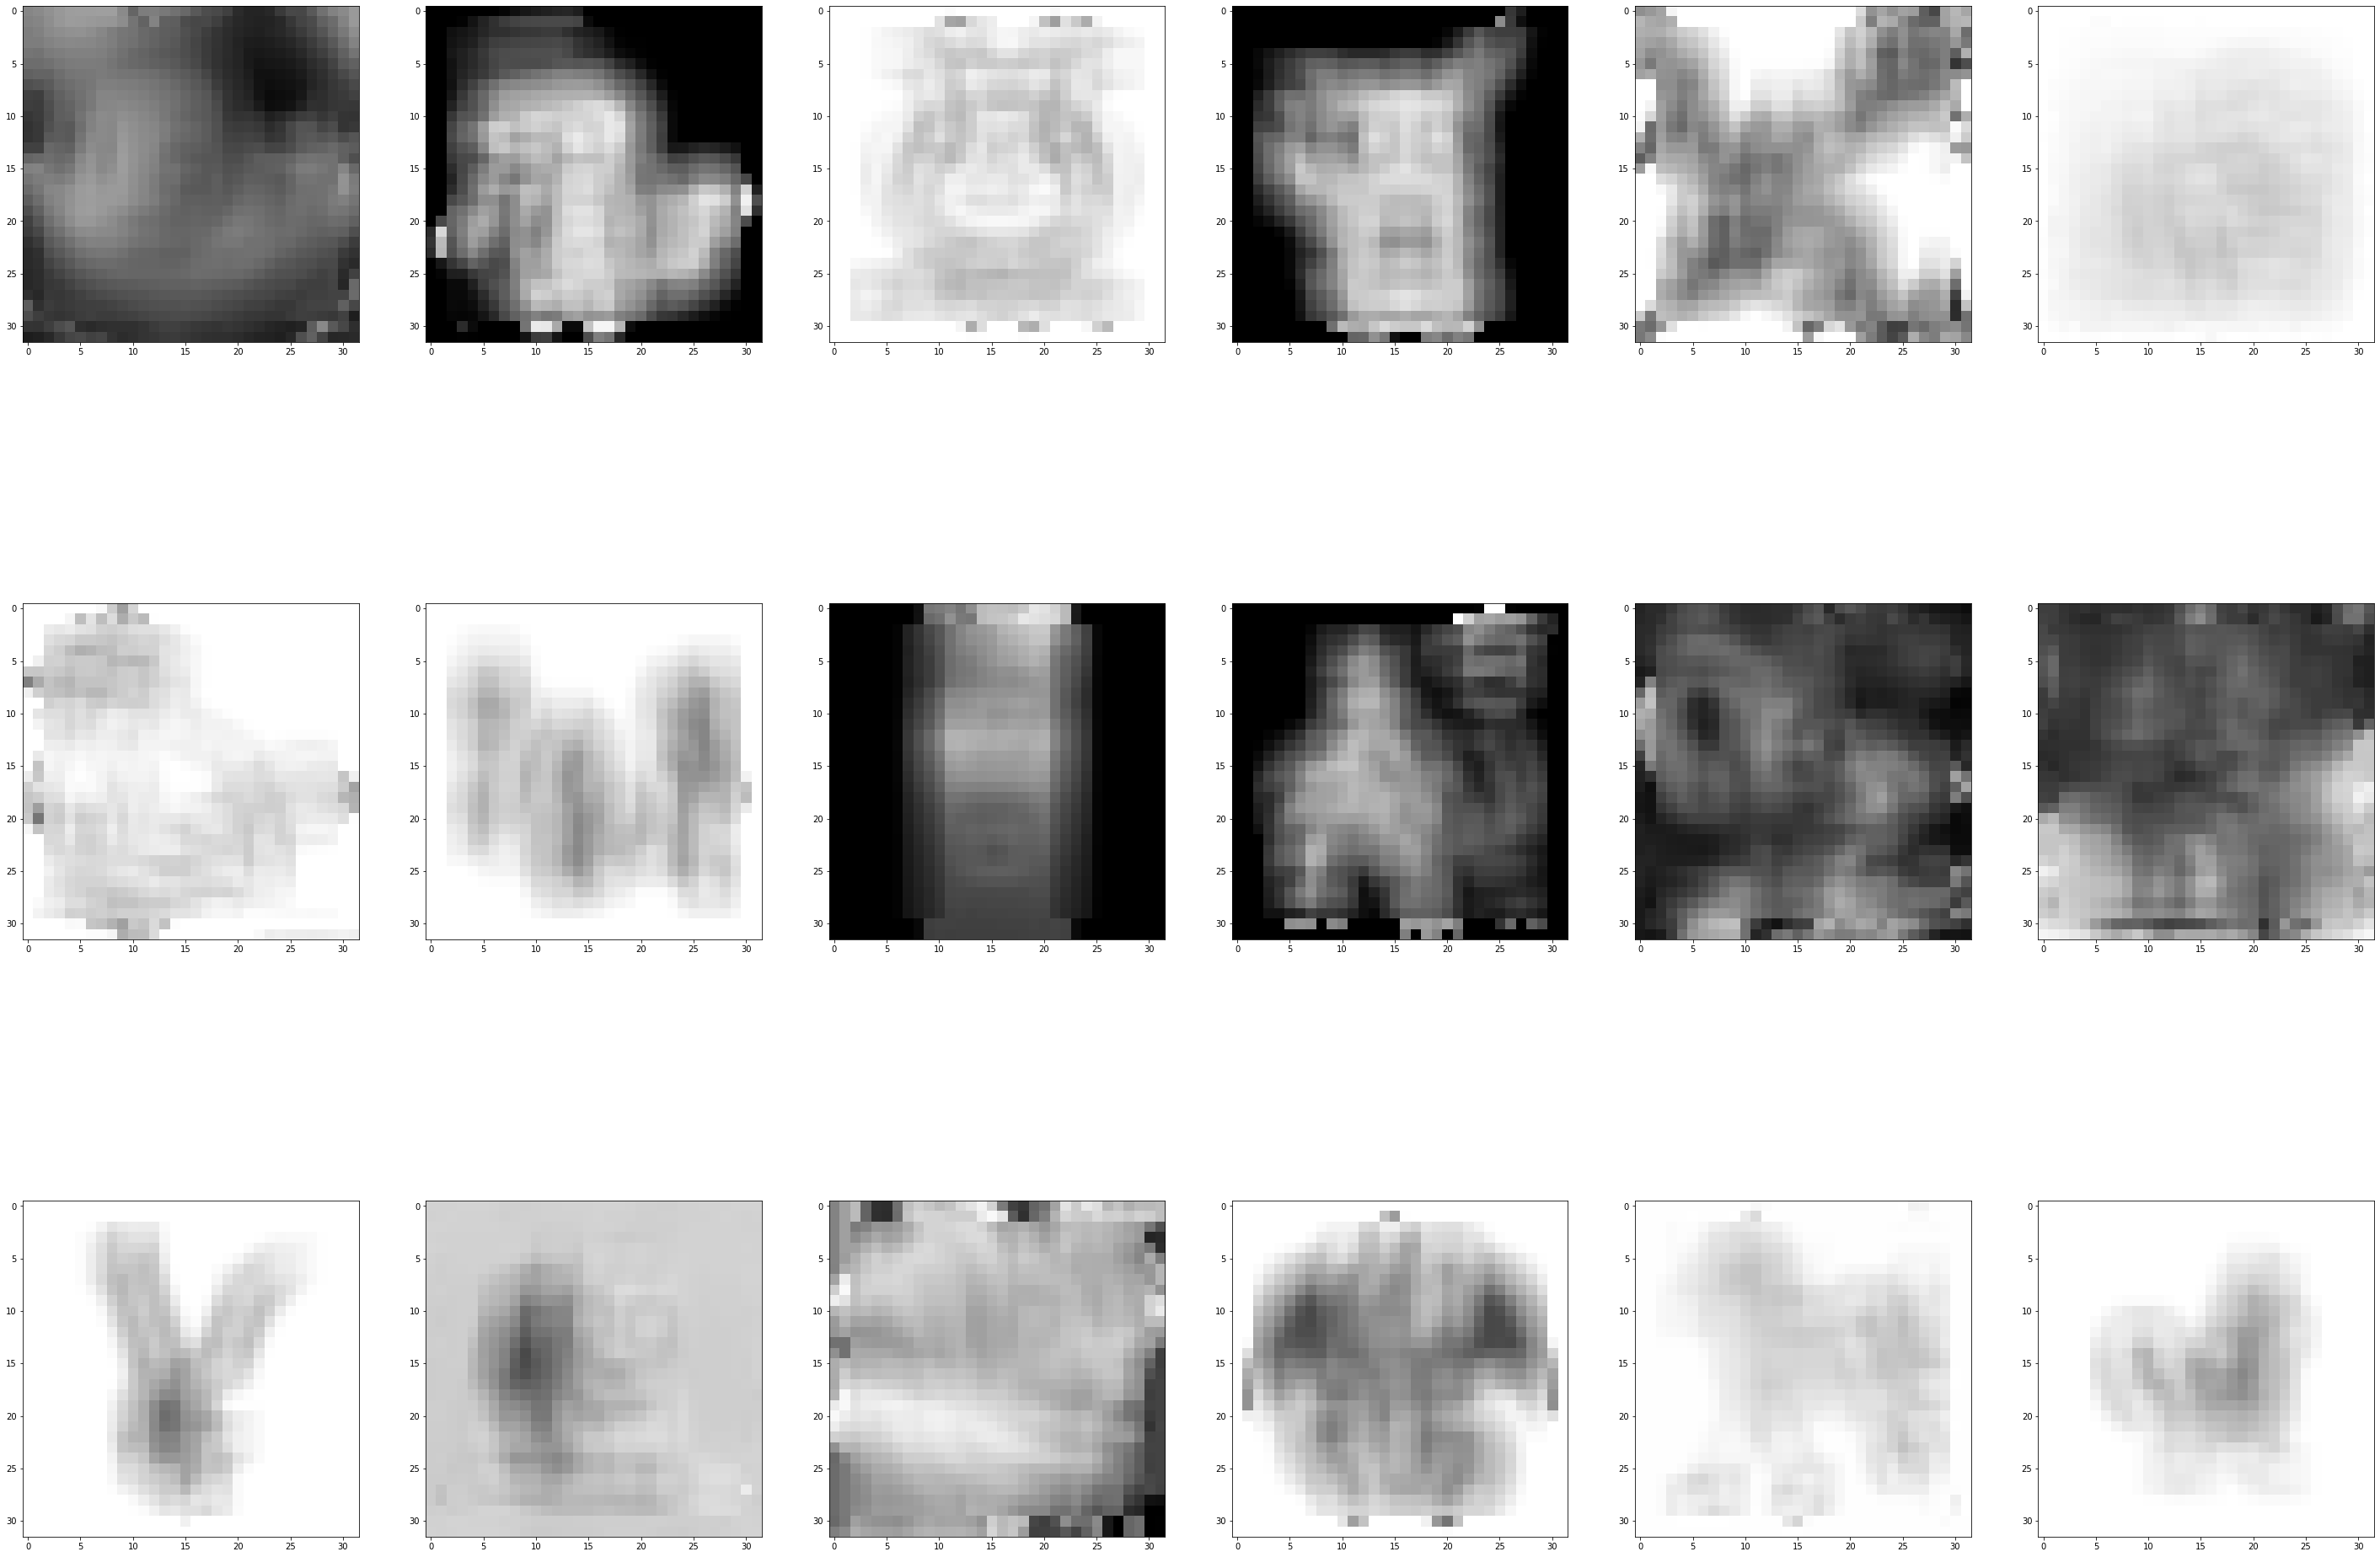

Training classifiers with filter: Blur
	 Using Classifier: Nearest Neighbor
		 Accuracy: 0.35865724 (+/- 0.03169397)
		 F1-Score: 0.34311333 (+/- 0.03253968)
		 Time it took to train: 11.03062653541565
	 Using Classifier: SVM
		 Accuracy: 0.25724382 (+/- 0.03765531)
		 F1-Score: 0.25694806 (+/- 0.03860521)
		 Time it took to train: 62.106228828430176
	 Using Classifier: RBF SVM
		 Accuracy: 0.26537102 (+/- 0.01622751)
		 F1-Score: 0.25674341 (+/- 0.01478813)
		 Time it took to train: 104.47435641288757
	 Using Classifier: Decision Tree
		 Accuracy: 0.22791519 (+/- 0.02654884)
		 F1-Score: 0.17968677 (+/- 0.01927251)
		 Time it took to train: 4.740833520889282
	 Using Classifier: Random Forest
		 Accuracy: 0.27561837 (+/- 0.01679839)
		 F1-Score: 0.22326134 (+/- 0.02777264)
		 Time it took to train: 1.9169018268585205
	 Using Classifier: AdaBoost
		 Accuracy: 0.19858657 (+/- 0.02130716)
		 F1-Score: 0.18041869 (+/- 0.02141412)
		 Time it took to train: 47.792436599731445
	 Using Classif

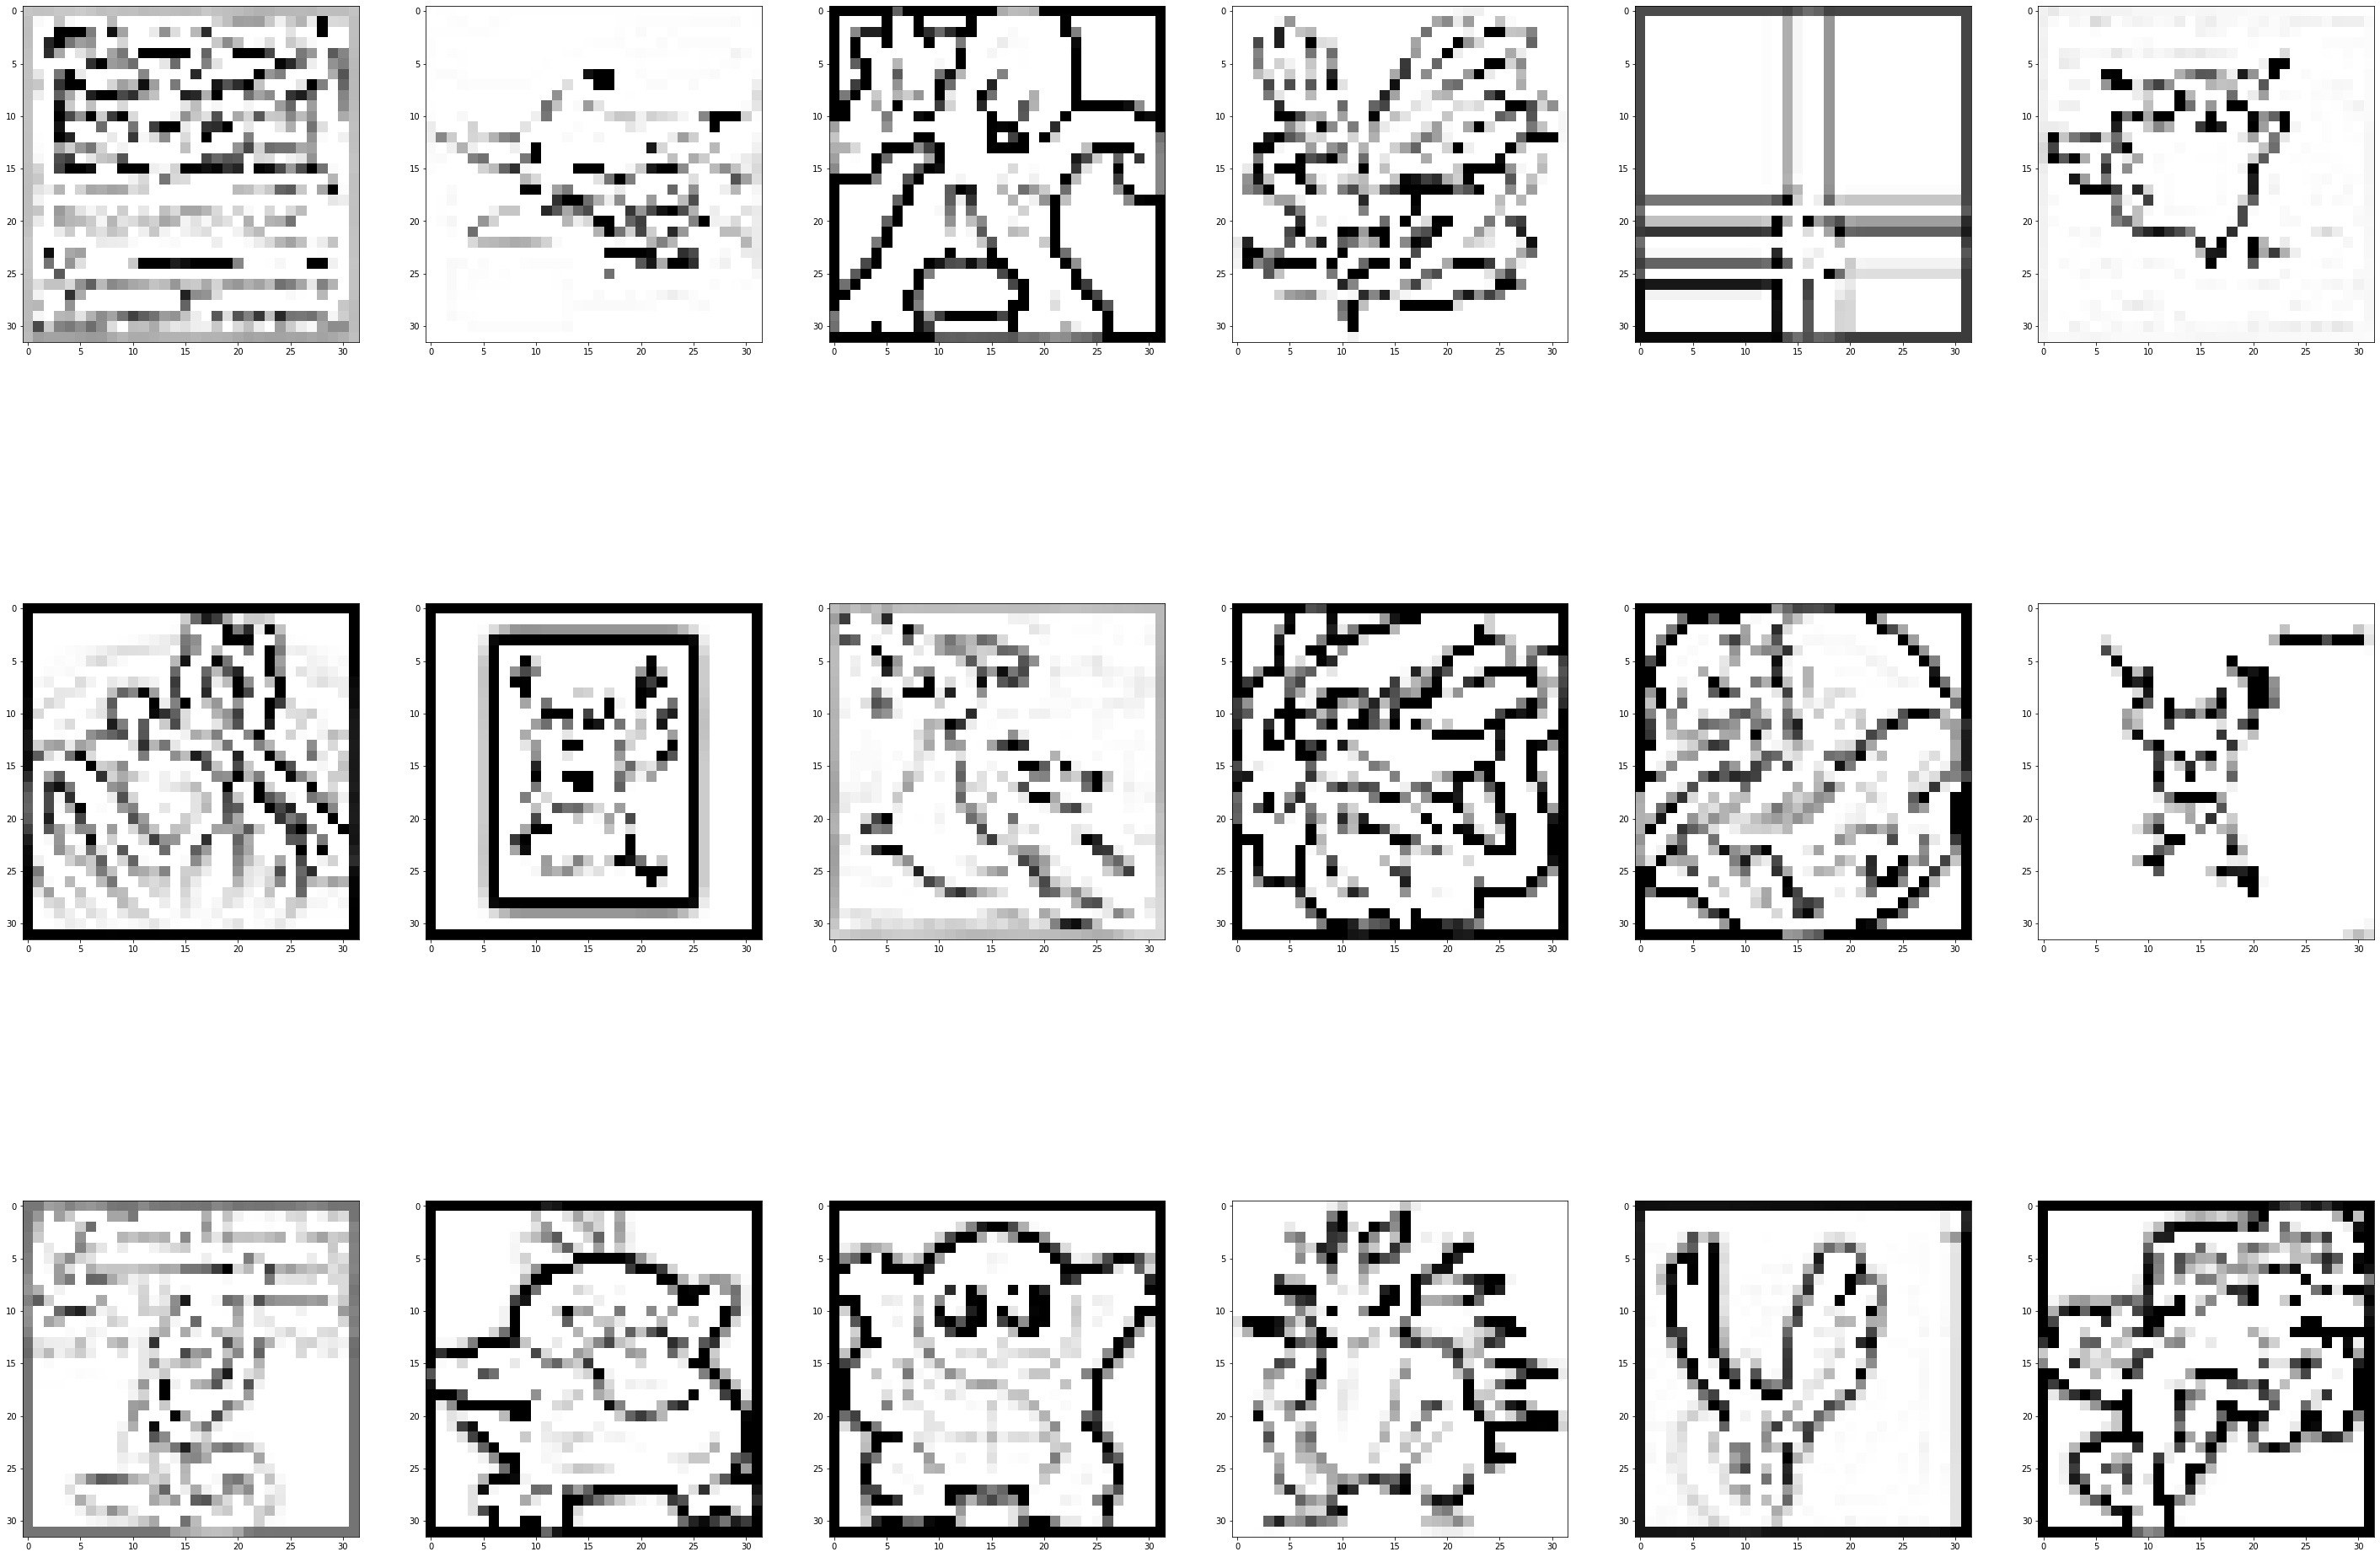

Training classifiers with filter: Contour
	 Using Classifier: Nearest Neighbor
		 Accuracy: 0.24805654 (+/- 0.02895802)
		 F1-Score: 0.23491523 (+/- 0.02903629)
		 Time it took to train: 14.402210712432861
	 Using Classifier: SVM
		 Accuracy: 0.44946996 (+/- 0.03347765)
		 F1-Score: 0.43975671 (+/- 0.03412260)
		 Time it took to train: 81.3781418800354
	 Using Classifier: RBF SVM
		 Accuracy: 0.26360424 (+/- 0.01816955)
		 F1-Score: 0.25575840 (+/- 0.01620653)
		 Time it took to train: 102.89398241043091
	 Using Classifier: Decision Tree
		 Accuracy: 0.19823322 (+/- 0.01755796)
		 F1-Score: 0.15636476 (+/- 0.02085970)
		 Time it took to train: 3.503633975982666
	 Using Classifier: Random Forest
		 Accuracy: 0.18939929 (+/- 0.01816955)
		 F1-Score: 0.13261700 (+/- 0.01790232)
		 Time it took to train: 1.9152886867523193
	 Using Classifier: AdaBoost
		 Accuracy: 0.15300353 (+/- 0.02649234)
		 F1-Score: 0.14490365 (+/- 0.02440253)
		 Time it took to train: 38.28071594238281
	 Using Classi

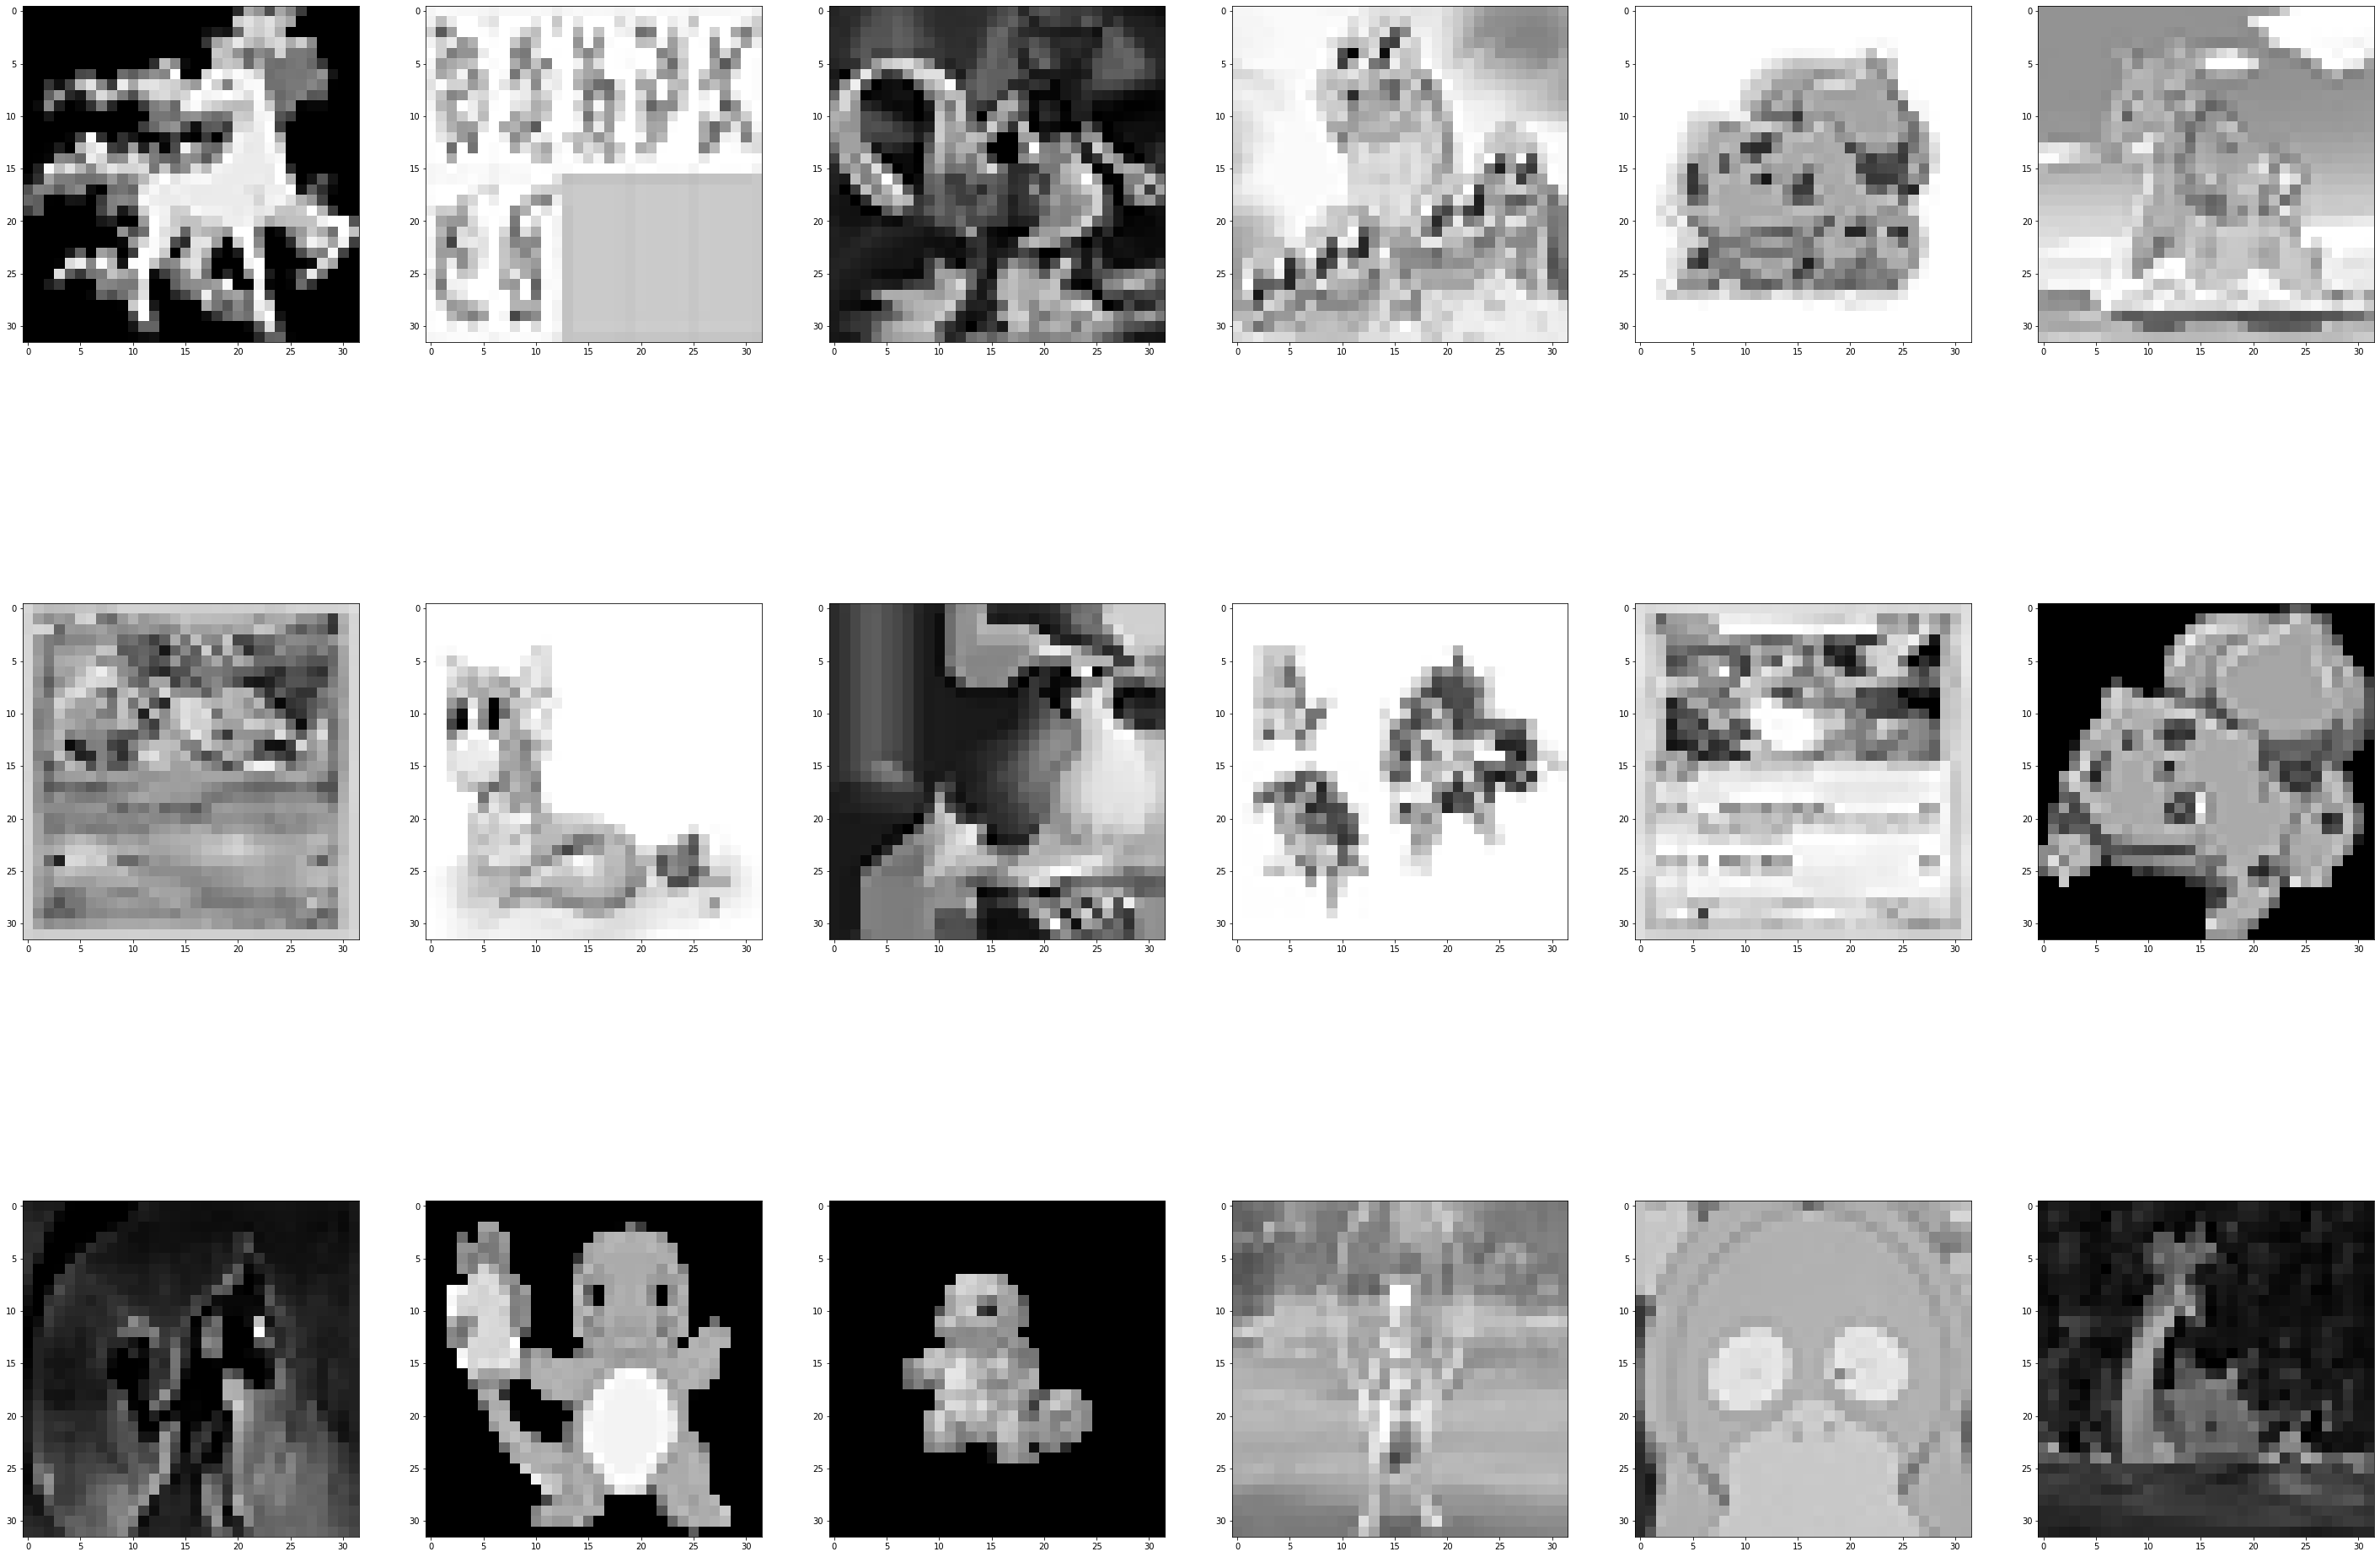

Training classifiers with filter: Detail
	 Using Classifier: Nearest Neighbor
		 Accuracy: 0.31272085 (+/- 0.03330752)
		 F1-Score: 0.29383297 (+/- 0.03716214)
		 Time it took to train: 13.2225661277771
	 Using Classifier: SVM
		 Accuracy: 0.43533569 (+/- 0.03450616)
		 F1-Score: 0.42326755 (+/- 0.03546188)
		 Time it took to train: 68.31475448608398
	 Using Classifier: RBF SVM
		 Accuracy: 0.26537102 (+/- 0.01622751)
		 F1-Score: 0.25674341 (+/- 0.01478813)
		 Time it took to train: 103.0270938873291
	 Using Classifier: Decision Tree
		 Accuracy: 0.22332155 (+/- 0.02571506)
		 F1-Score: 0.16979684 (+/- 0.02290061)
		 Time it took to train: 4.622687101364136
	 Using Classifier: Random Forest
		 Accuracy: 0.26855124 (+/- 0.01473968)
		 F1-Score: 0.21904295 (+/- 0.01213506)
		 Time it took to train: 1.9597842693328857
	 Using Classifier: AdaBoost
		 Accuracy: 0.18692580 (+/- 0.01918894)
		 F1-Score: 0.17199272 (+/- 0.01946736)
		 Time it took to train: 46.822959661483765
	 Using Classifi

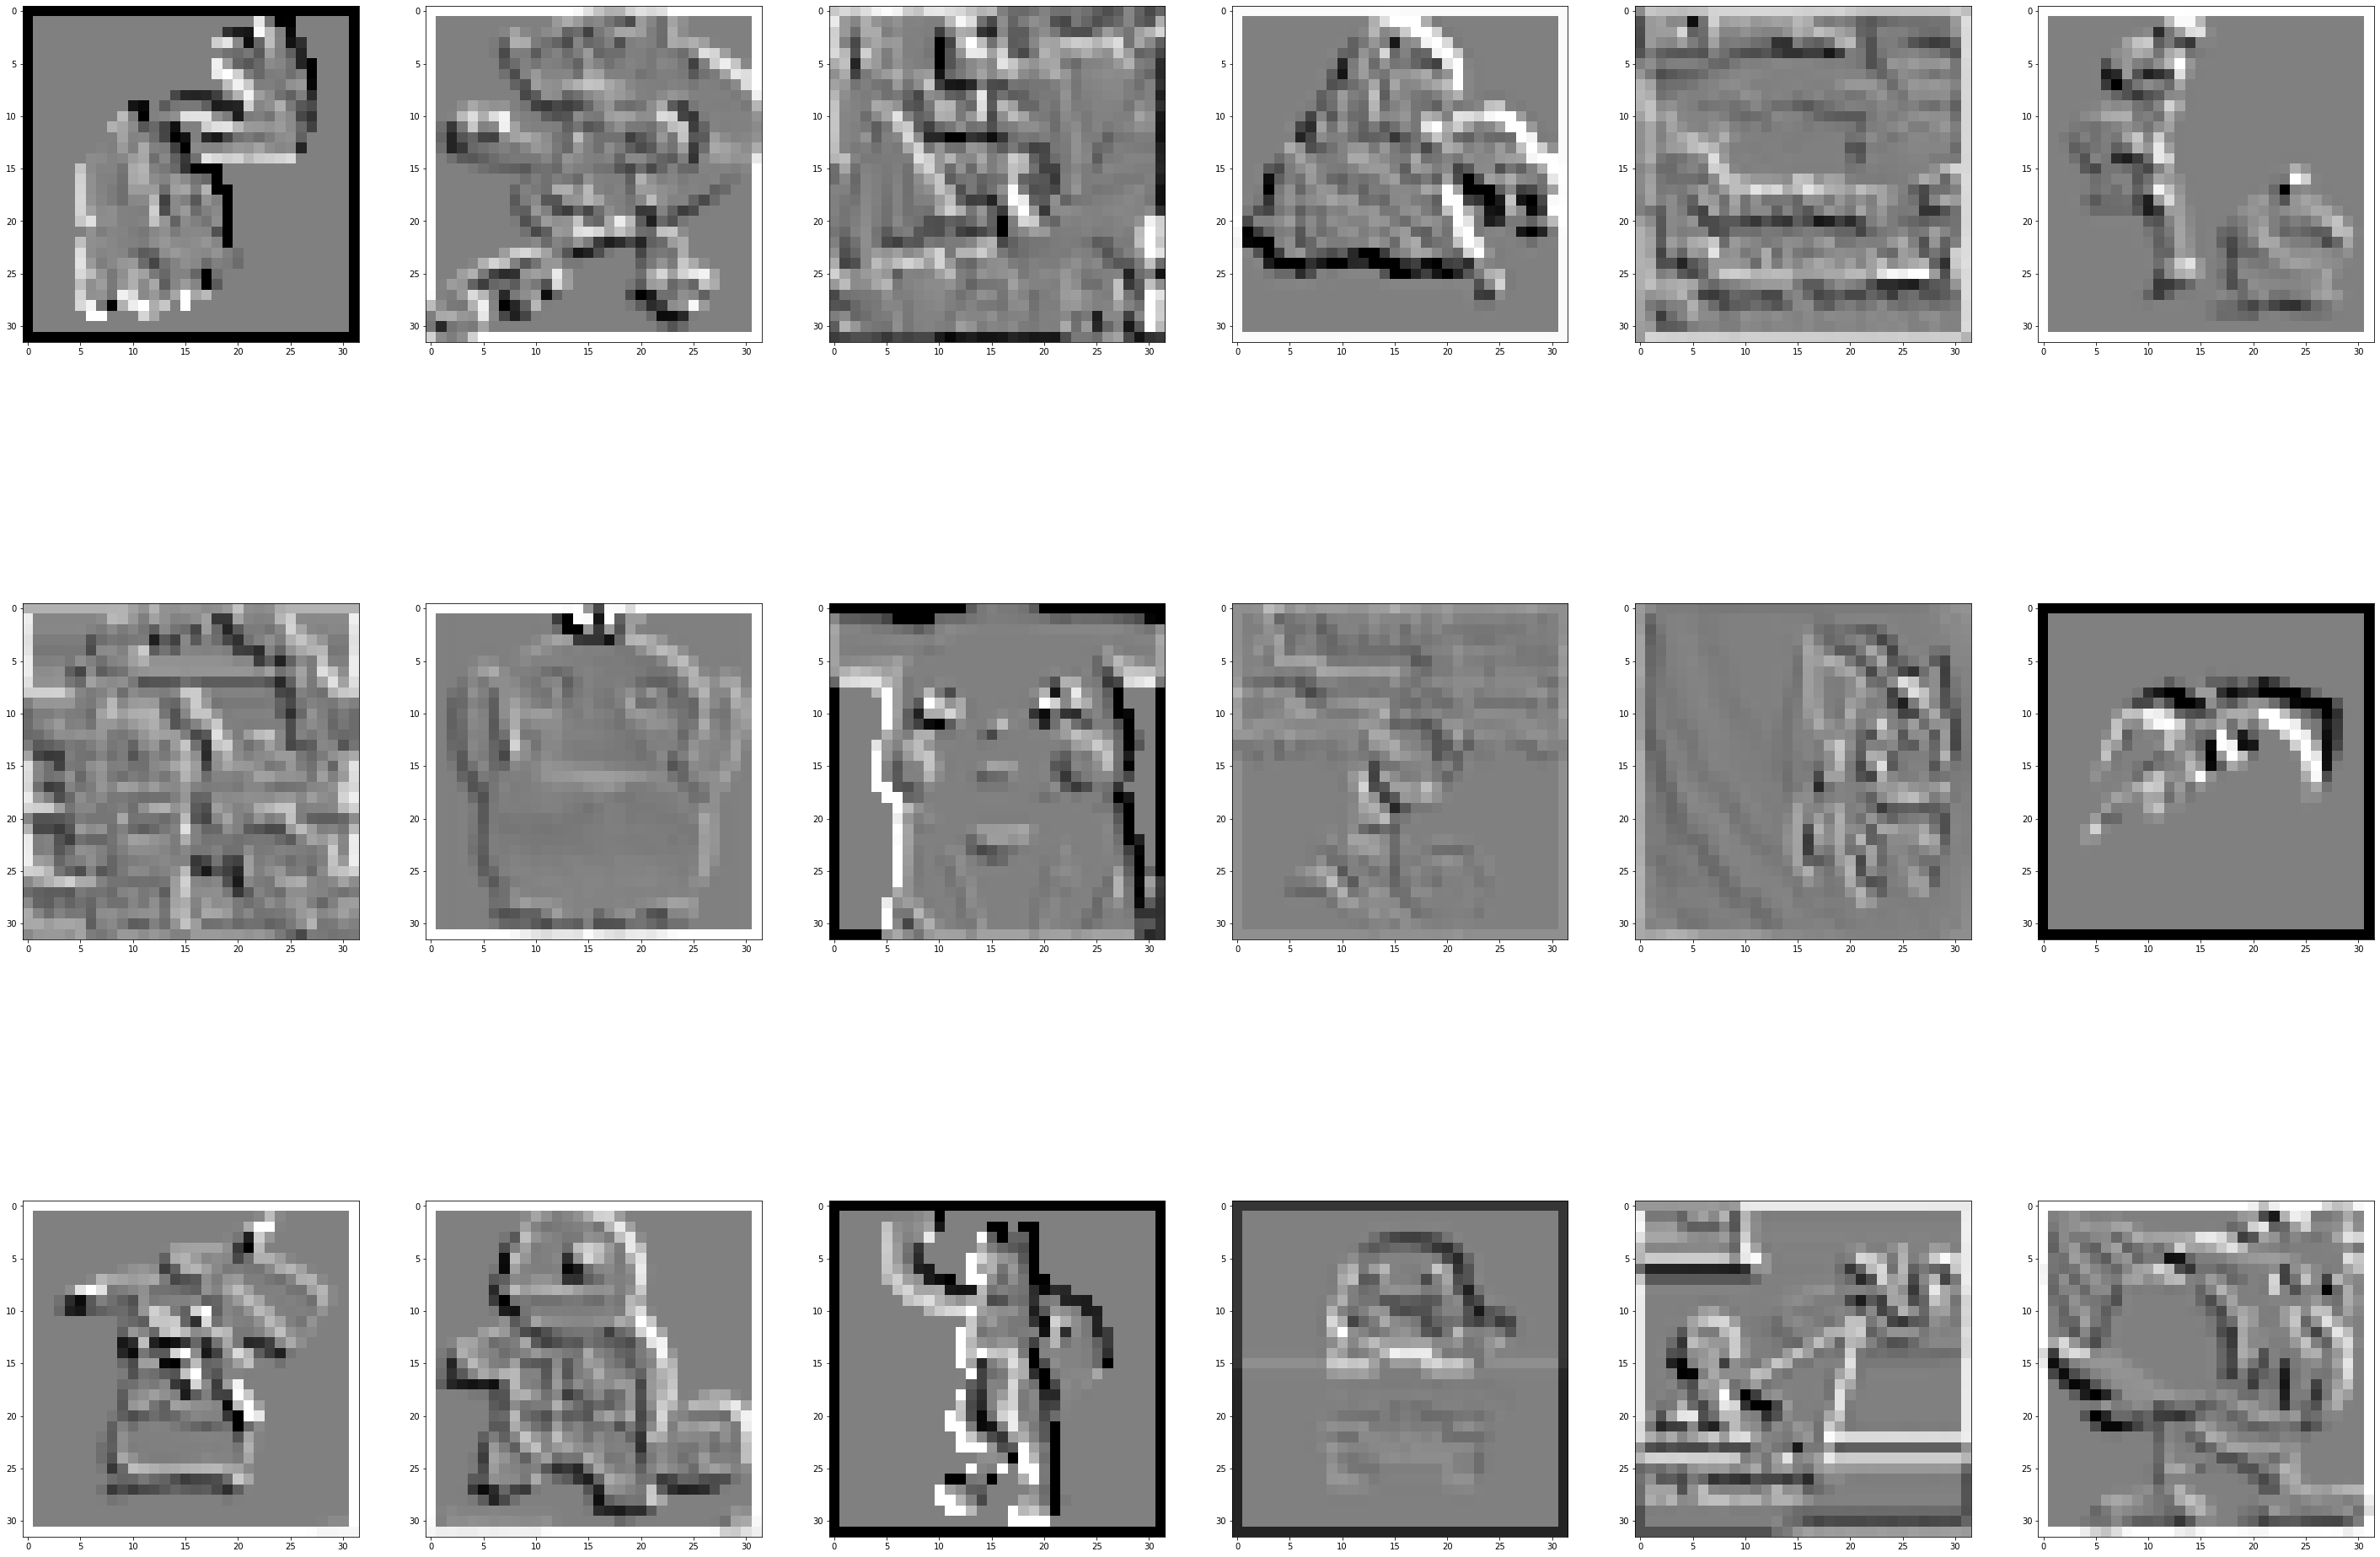

Training classifiers with filter: Emboxx
	 Using Classifier: Nearest Neighbor
		 Accuracy: 0.24982332 (+/- 0.02240684)
		 F1-Score: 0.23637952 (+/- 0.02298107)
		 Time it took to train: 12.847815036773682
	 Using Classifier: SVM
		 Accuracy: 0.42120141 (+/- 0.03218459)
		 F1-Score: 0.40803414 (+/- 0.02847539)
		 Time it took to train: 70.80288553237915
	 Using Classifier: RBF SVM
		 Accuracy: 0.26537102 (+/- 0.01622751)
		 F1-Score: 0.25674341 (+/- 0.01478813)
		 Time it took to train: 103.17904925346375
	 Using Classifier: Decision Tree
		 Accuracy: 0.18056537 (+/- 0.01326383)
		 F1-Score: 0.13991678 (+/- 0.01897884)
		 Time it took to train: 4.290182113647461
	 Using Classifier: Random Forest
		 Accuracy: 0.18763251 (+/- 0.01755796)
		 F1-Score: 0.14400440 (+/- 0.02170412)
		 Time it took to train: 1.942481517791748
	 Using Classifier: AdaBoost
		 Accuracy: 0.13568905 (+/- 0.01658897)
		 F1-Score: 0.12158238 (+/- 0.01665833)
		 Time it took to train: 44.39581346511841
	 Using Classif

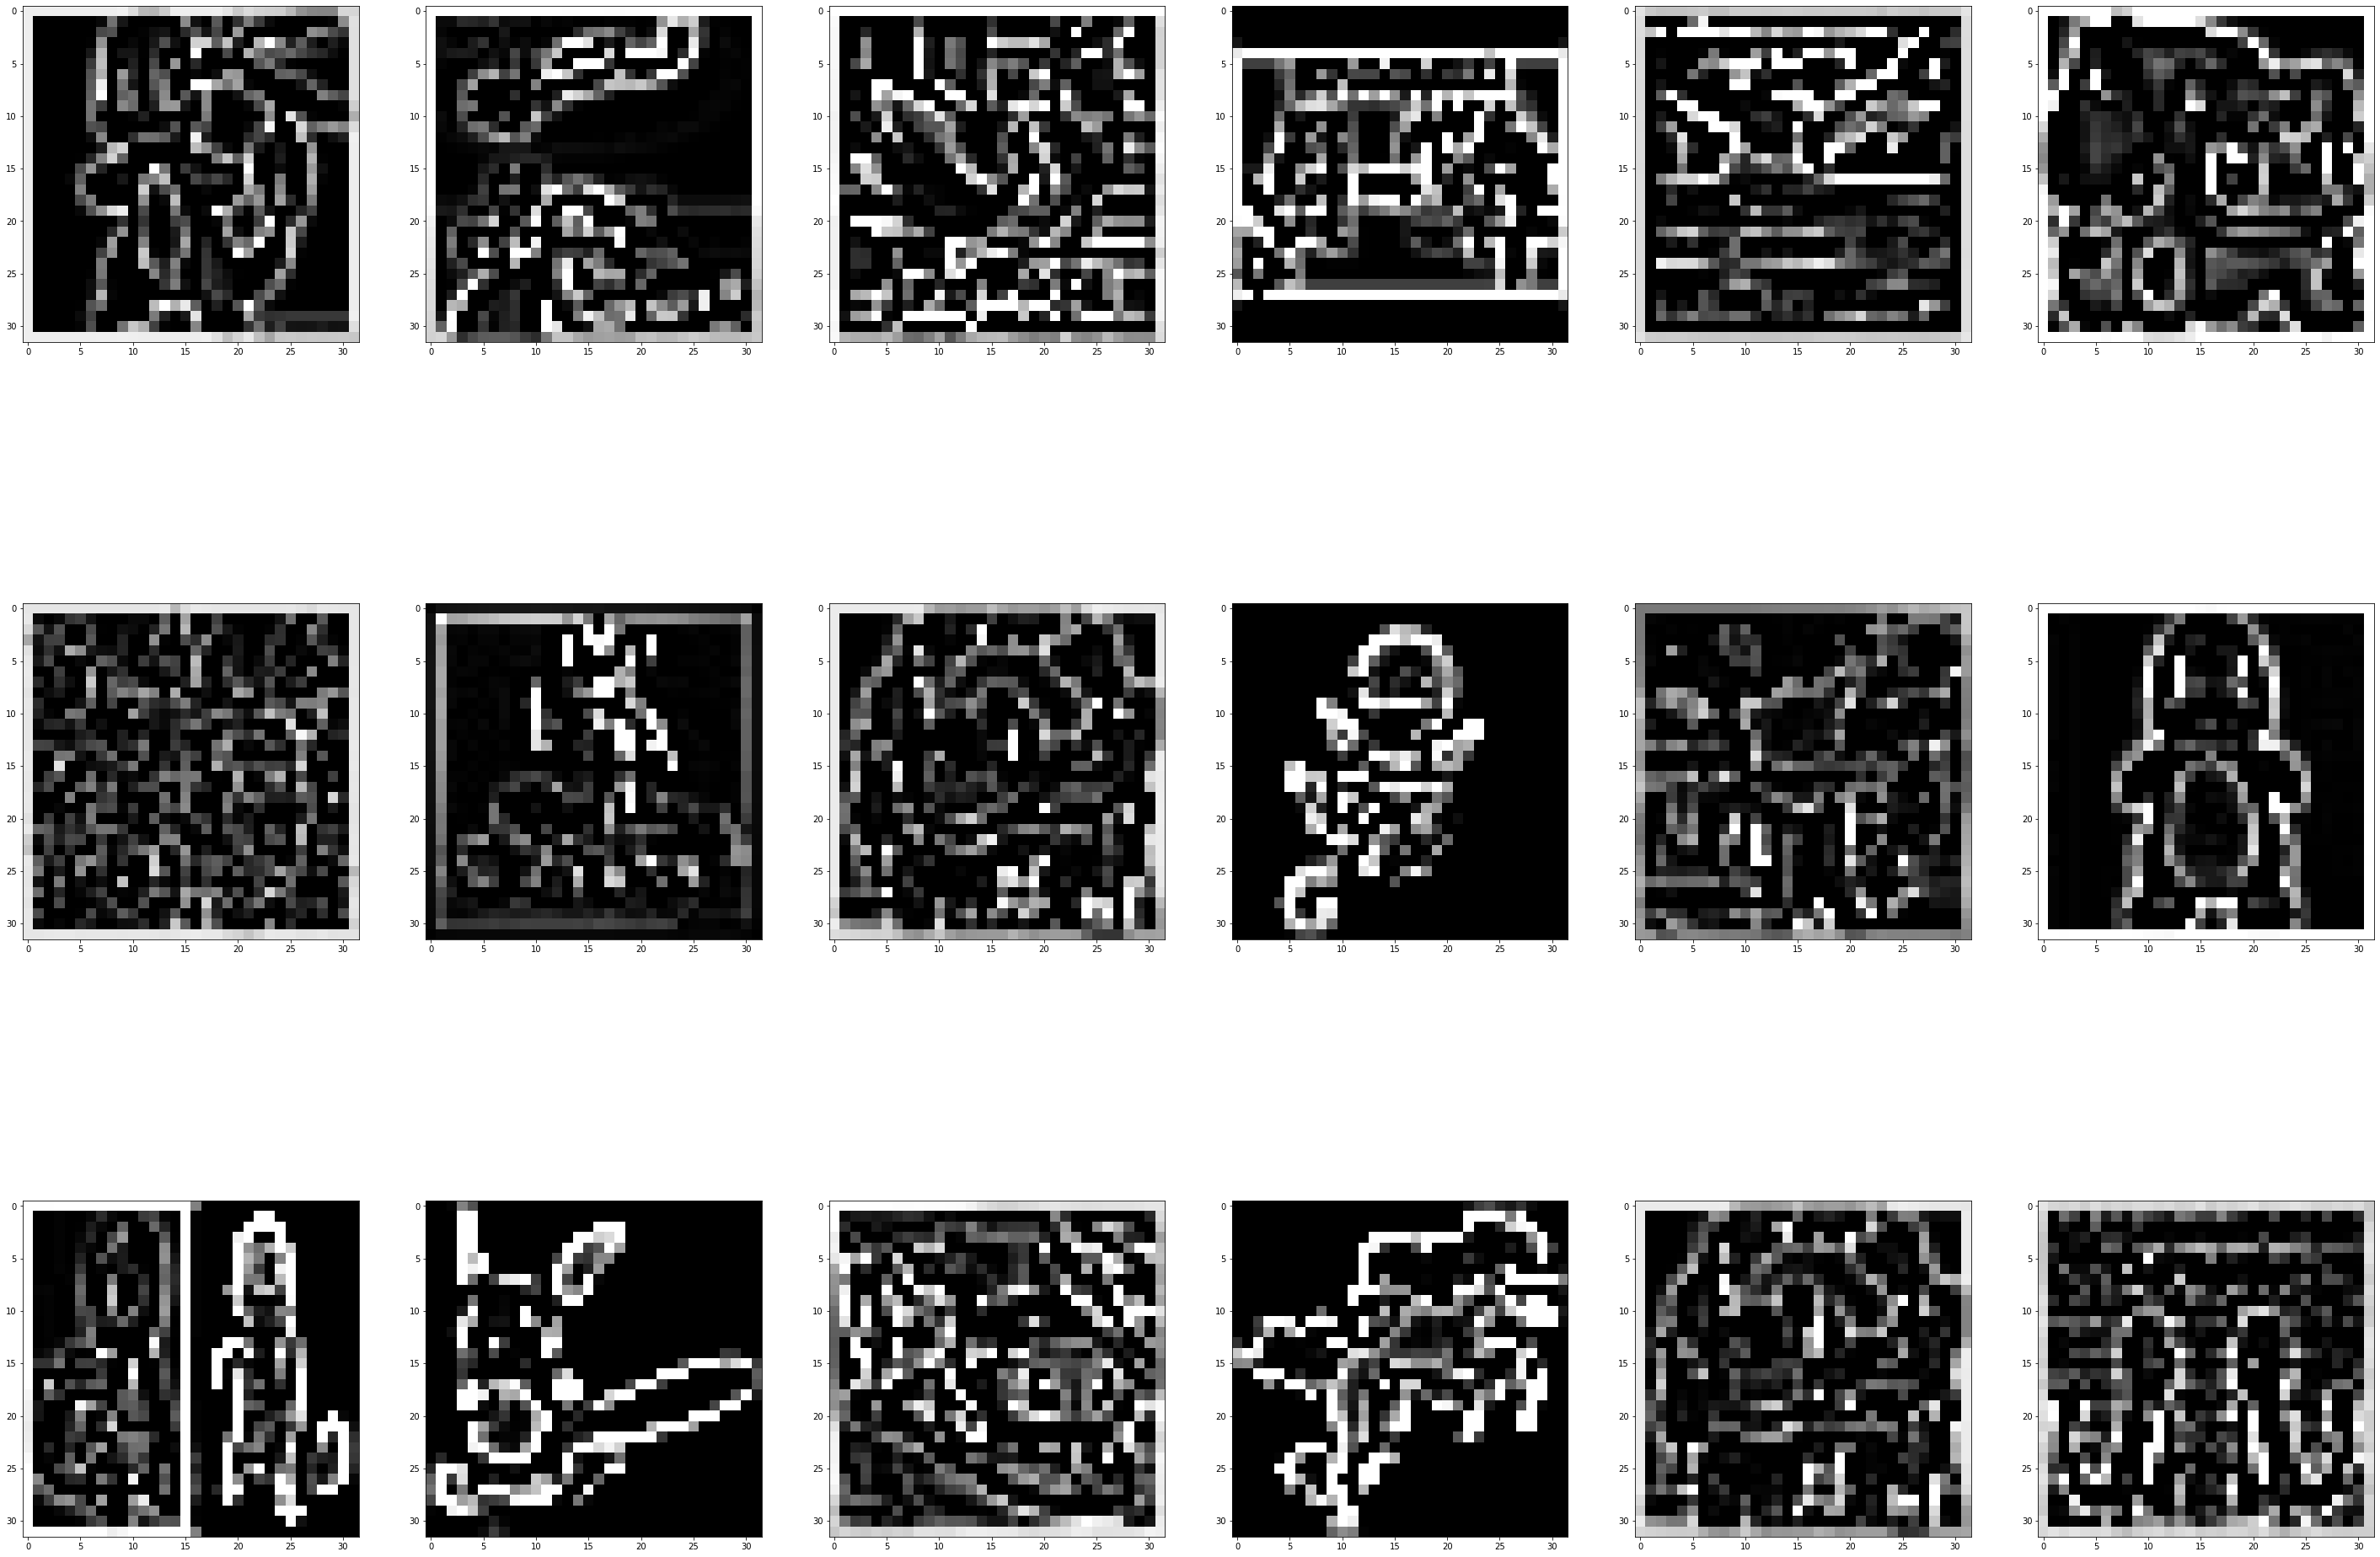

Training classifiers with filter: Find Edges
	 Using Classifier: Nearest Neighbor
		 Accuracy: 0.26395760 (+/- 0.03019289)
		 F1-Score: 0.25242688 (+/- 0.03196320)
		 Time it took to train: 14.562634706497192
	 Using Classifier: SVM
		 Accuracy: 0.44876325 (+/- 0.03273084)
		 F1-Score: 0.44059356 (+/- 0.03278981)
		 Time it took to train: 80.9659366607666
	 Using Classifier: RBF SVM
		 Accuracy: 0.26360424 (+/- 0.01816955)
		 F1-Score: 0.25575840 (+/- 0.01620653)
		 Time it took to train: 103.0689926147461
	 Using Classifier: Decision Tree
		 Accuracy: 0.19752650 (+/- 0.01951157)
		 F1-Score: 0.16652666 (+/- 0.02582526)
		 Time it took to train: 3.715769052505493
	 Using Classifier: Random Forest
		 Accuracy: 0.19187279 (+/- 0.01672763)
		 F1-Score: 0.13074931 (+/- 0.01969620)
		 Time it took to train: 1.8945872783660889
	 Using Classifier: AdaBoost
		 Accuracy: 0.16148410 (+/- 0.01293981)
		 F1-Score: 0.15254616 (+/- 0.01563427)
		 Time it took to train: 40.10395622253418
	 Using Clas

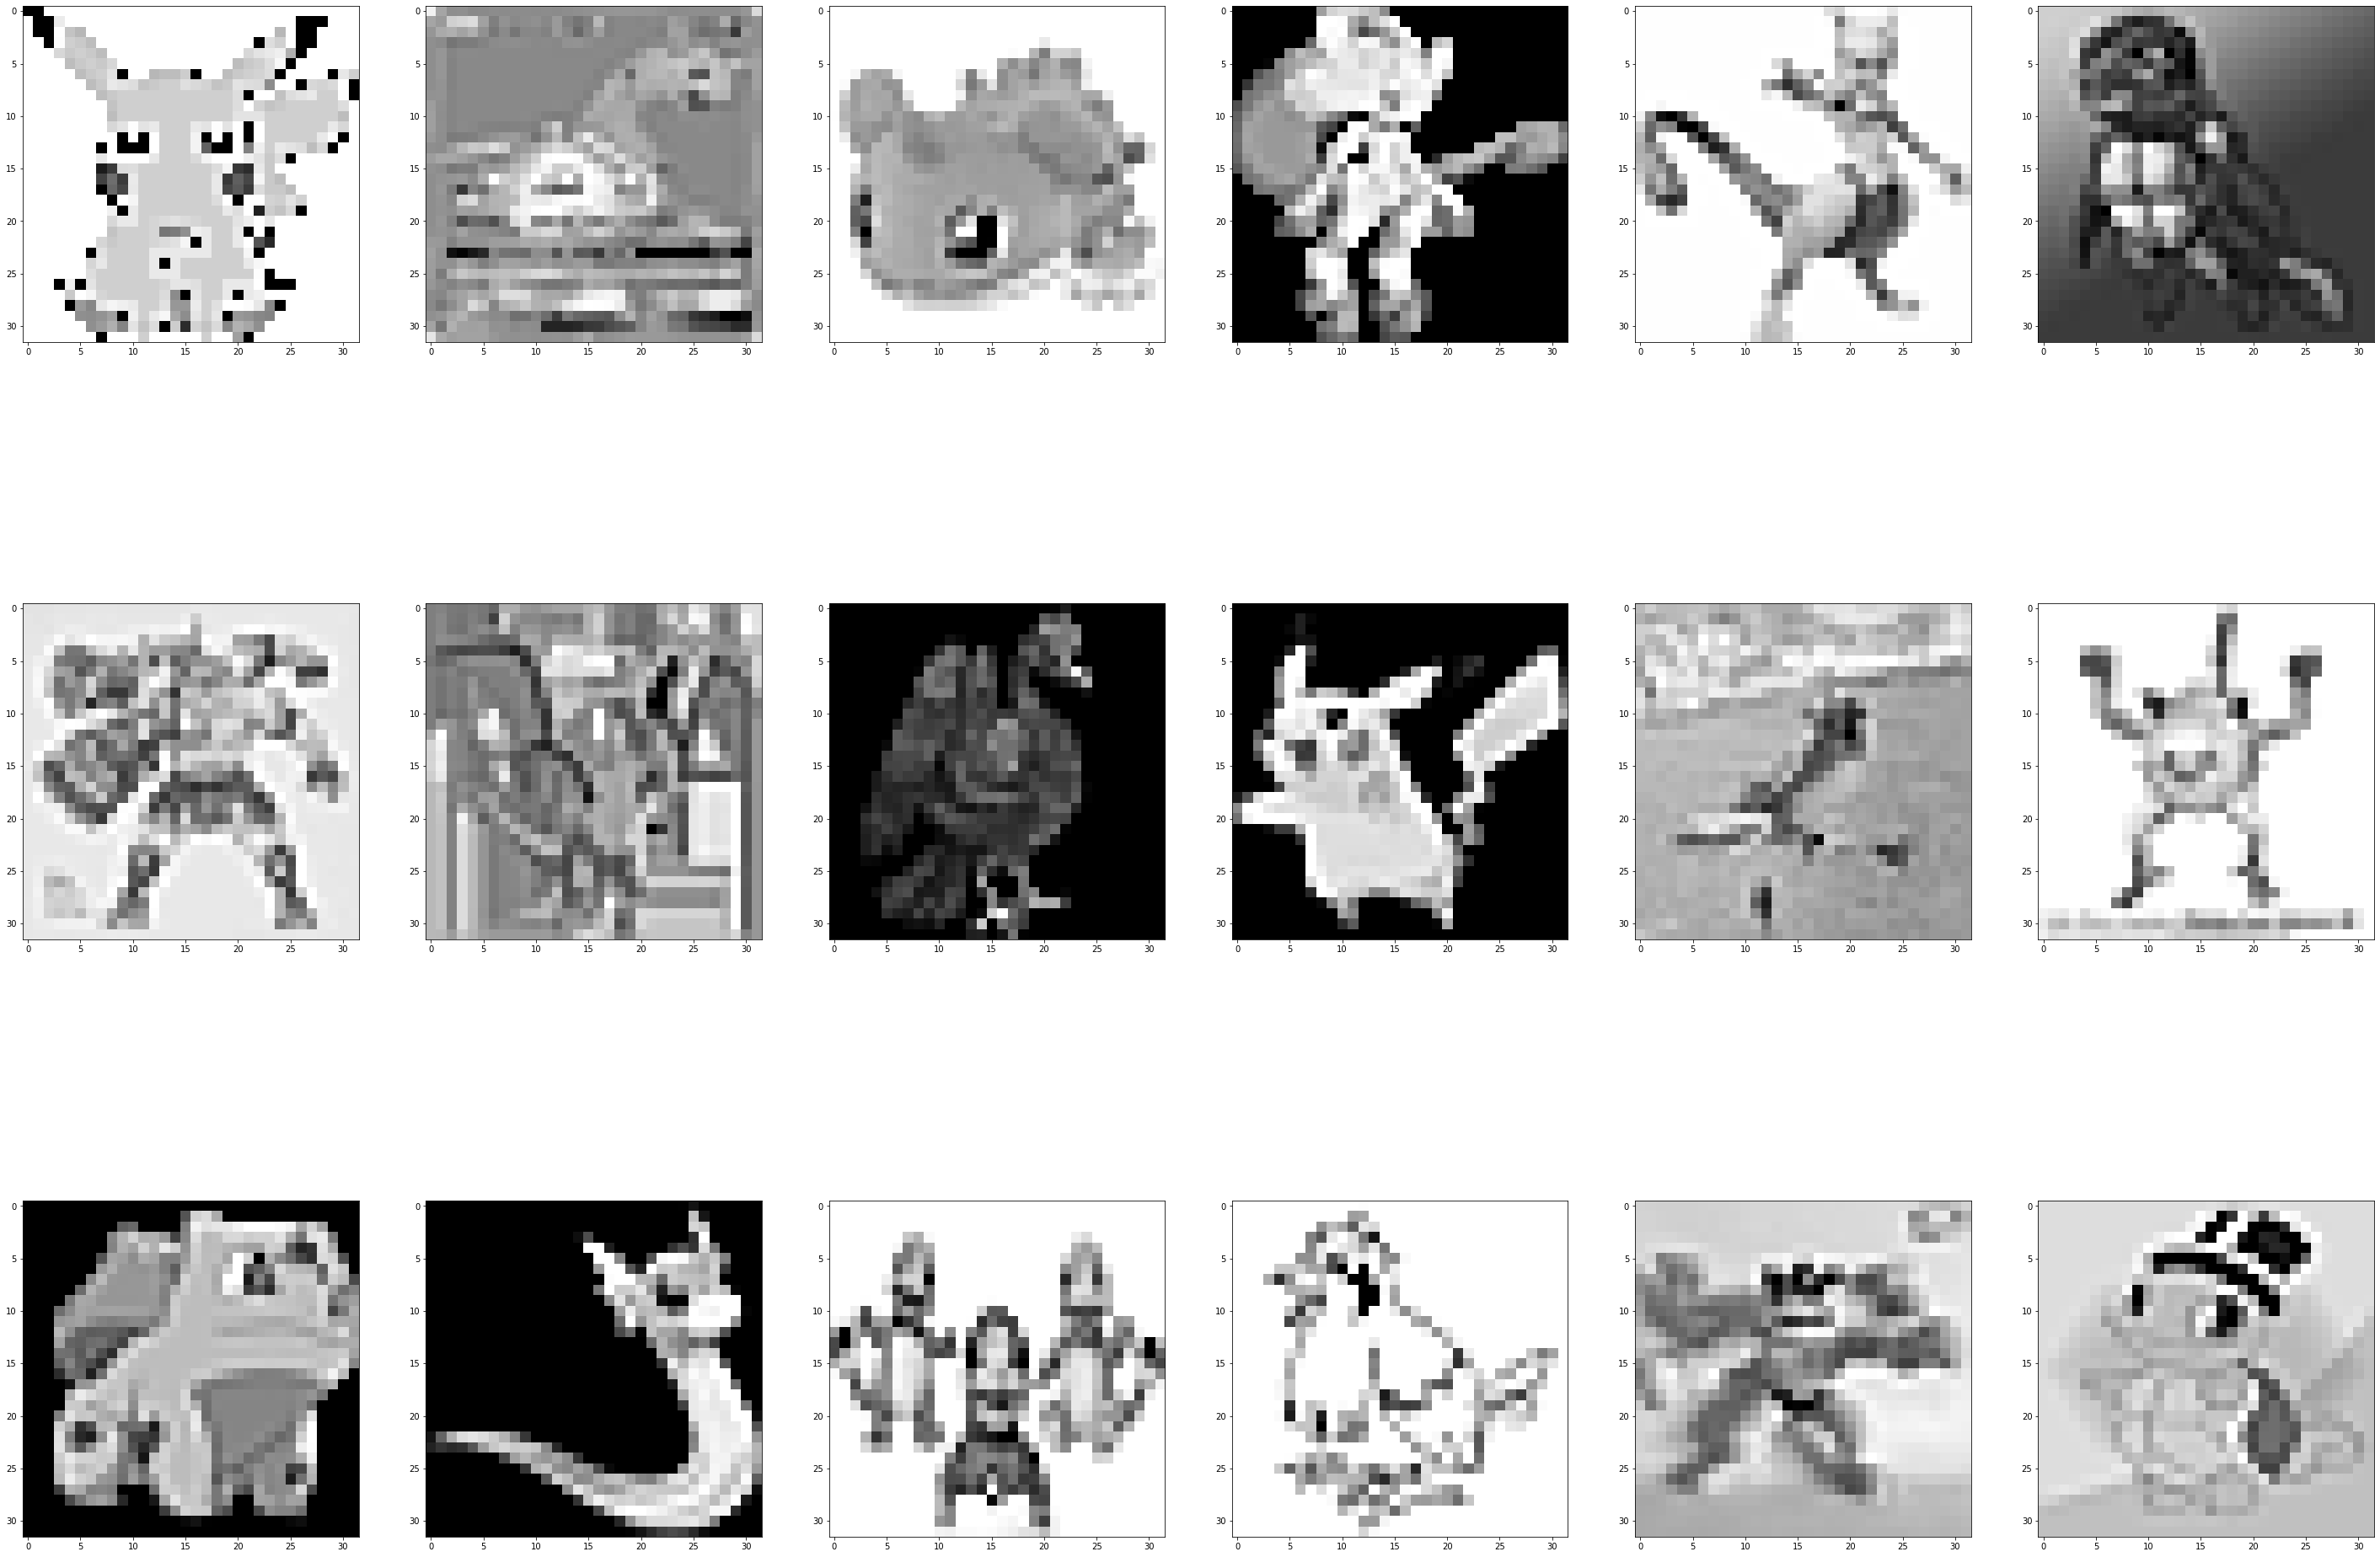

Training classifiers with filter: Sharpen
	 Using Classifier: Nearest Neighbor
		 Accuracy: 0.30106007 (+/- 0.03047076)
		 F1-Score: 0.27934256 (+/- 0.03106805)
		 Time it took to train: 13.789214134216309
	 Using Classifier: SVM
		 Accuracy: 0.43568905 (+/- 0.03199978)
		 F1-Score: 0.42196412 (+/- 0.03279343)
		 Time it took to train: 74.71073913574219
	 Using Classifier: RBF SVM
		 Accuracy: 0.26537102 (+/- 0.01622751)
		 F1-Score: 0.25674341 (+/- 0.01478813)
		 Time it took to train: 117.69650745391846
	 Using Classifier: Decision Tree
		 Accuracy: 0.21166078 (+/- 0.02007925)
		 F1-Score: 0.16865000 (+/- 0.01516935)
		 Time it took to train: 5.319350004196167
	 Using Classifier: Random Forest
		 Accuracy: 0.25477032 (+/- 0.01567965)
		 F1-Score: 0.19414683 (+/- 0.02100080)
		 Time it took to train: 2.1558141708374023
	 Using Classifier: AdaBoost
		 Accuracy: 0.17632509 (+/- 0.03656689)
		 F1-Score: 0.16579463 (+/- 0.03353038)
		 Time it took to train: 50.94236969947815
	 Using Class

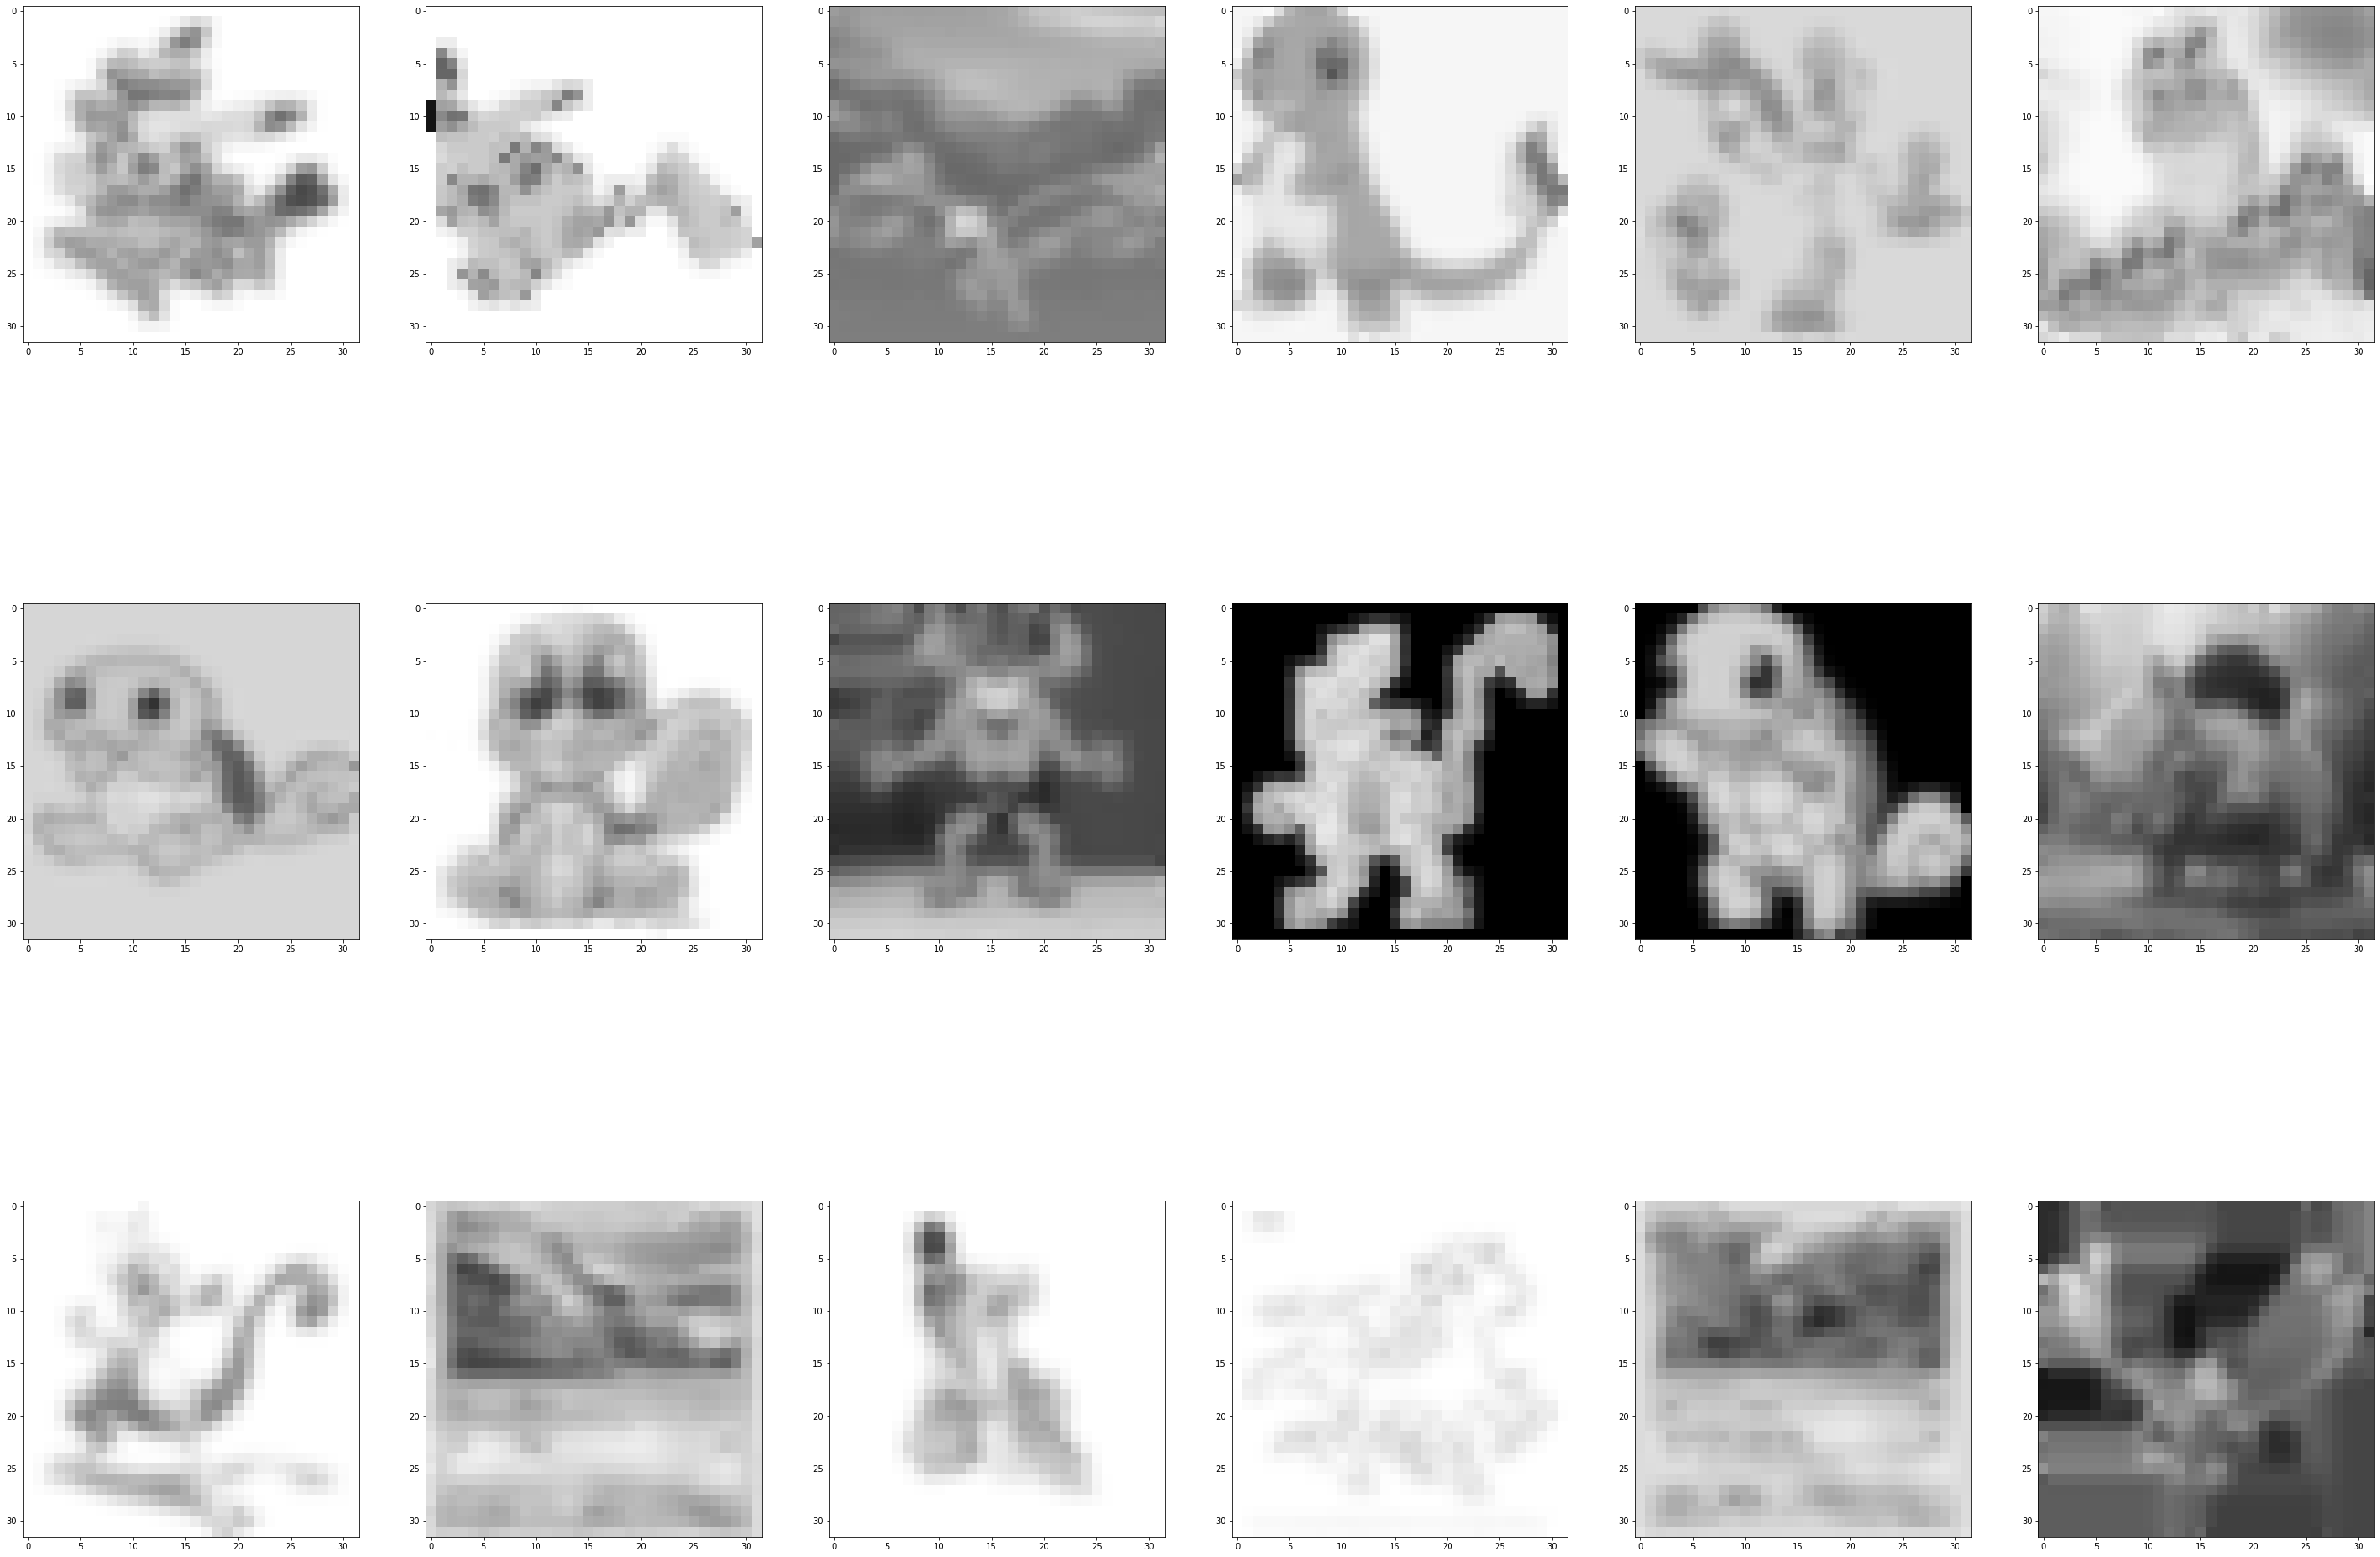

Training classifiers with filter: Smooth
	 Using Classifier: Nearest Neighbor
		 Accuracy: 0.34664311 (+/- 0.03251843)
		 F1-Score: 0.33068939 (+/- 0.03176255)
		 Time it took to train: 11.772041082382202
	 Using Classifier: SVM
		 Accuracy: 0.32544170 (+/- 0.03361351)
		 F1-Score: 0.32198977 (+/- 0.03451500)
		 Time it took to train: 61.7629976272583
	 Using Classifier: RBF SVM
		 Accuracy: 0.26537102 (+/- 0.01622751)
		 F1-Score: 0.25674341 (+/- 0.01478813)
		 Time it took to train: 102.6871349811554
	 Using Classifier: Decision Tree
		 Accuracy: 0.23568905 (+/- 0.02407240)
		 F1-Score: 0.18965357 (+/- 0.02525742)
		 Time it took to train: 4.783259153366089
	 Using Classifier: Random Forest
		 Accuracy: 0.27632509 (+/- 0.02643336)
		 F1-Score: 0.22044566 (+/- 0.02258844)
		 Time it took to train: 1.8904869556427002
	 Using Classifier: AdaBoost
		 Accuracy: 0.18763251 (+/- 0.02157793)
		 F1-Score: 0.17481023 (+/- 0.01831432)
		 Time it took to train: 48.030179023742676
	 Using Classif

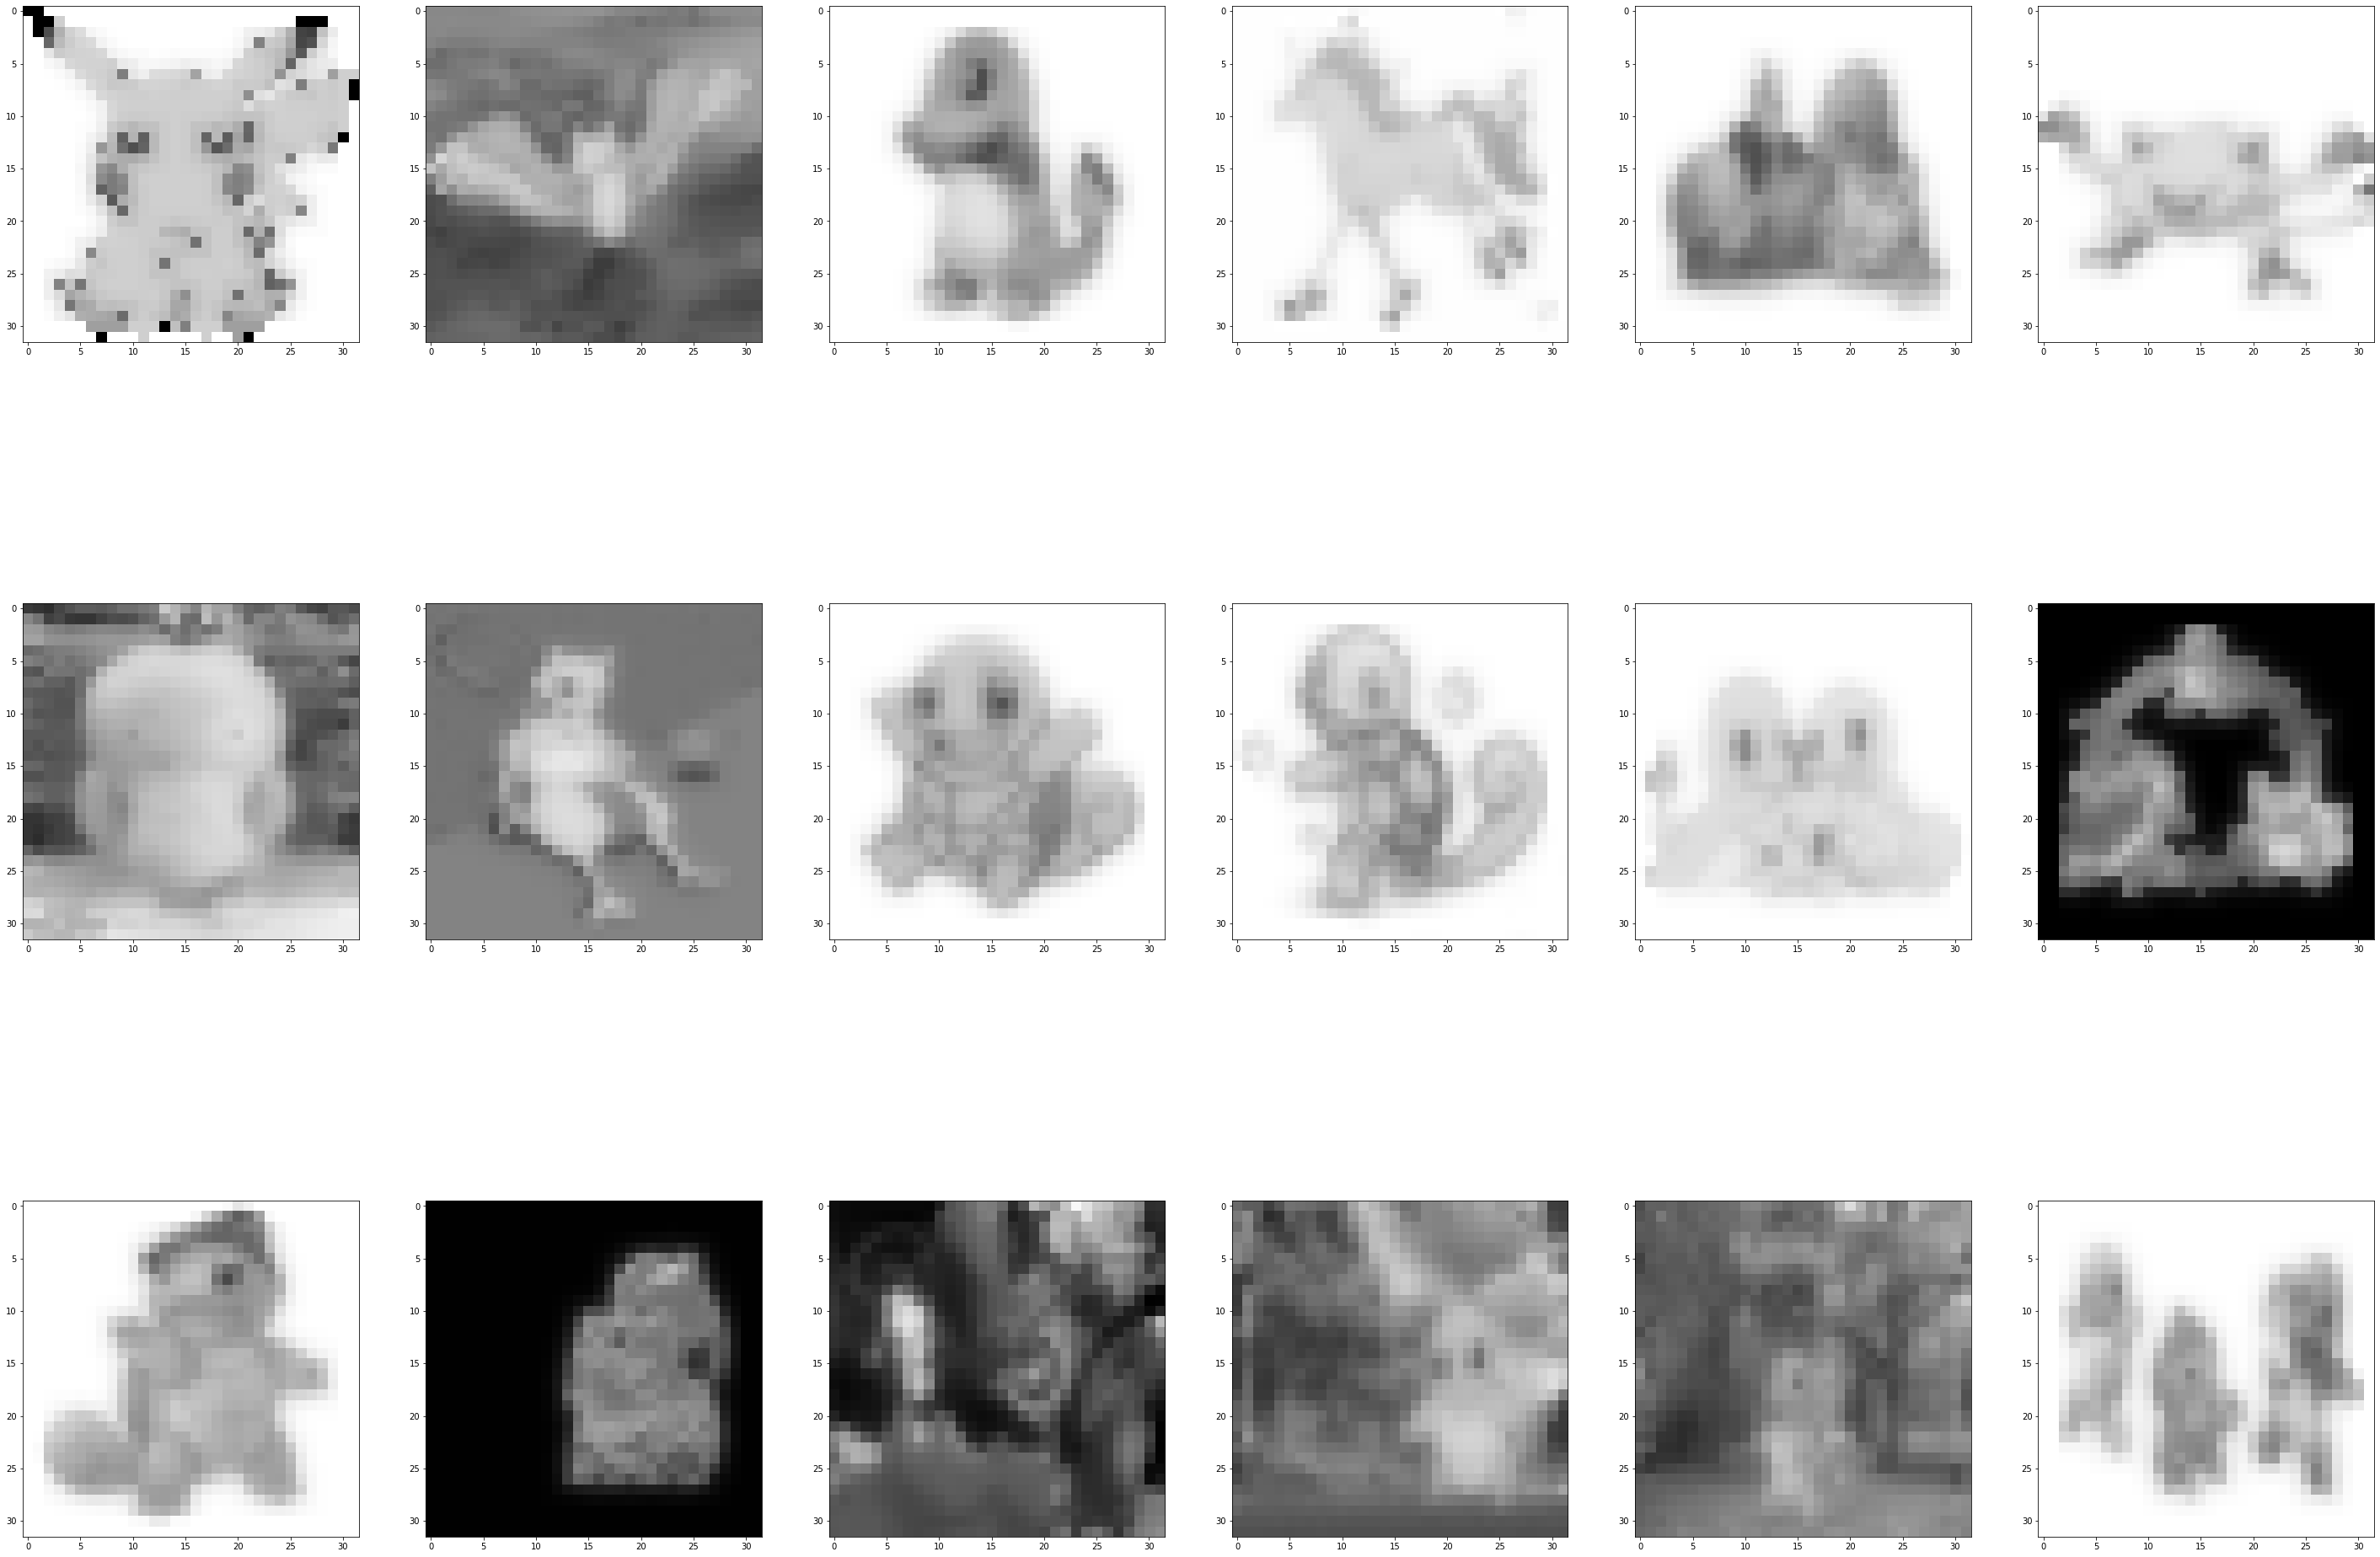

Training classifiers with filter: Smooth More
	 Using Classifier: Nearest Neighbor
		 Accuracy: 0.34275618 (+/- 0.02746199)
		 F1-Score: 0.32754342 (+/- 0.02877283)
		 Time it took to train: 11.852550745010376
	 Using Classifier: SVM
		 Accuracy: 0.35441696 (+/- 0.02048556)
		 F1-Score: 0.35111245 (+/- 0.02082694)
		 Time it took to train: 62.78797650337219
	 Using Classifier: RBF SVM
		 Accuracy: 0.26537102 (+/- 0.01622751)
		 F1-Score: 0.25674341 (+/- 0.01478813)
		 Time it took to train: 103.00284814834595
	 Using Classifier: Decision Tree
		 Accuracy: 0.22579505 (+/- 0.01925390)
		 F1-Score: 0.18629255 (+/- 0.01945681)
		 Time it took to train: 4.765873908996582
	 Using Classifier: Random Forest
		 Accuracy: 0.28162544 (+/- 0.02132180)
		 F1-Score: 0.20981221 (+/- 0.02721559)
		 Time it took to train: 1.901038408279419
	 Using Classifier: AdaBoost
		 Accuracy: 0.20494700 (+/- 0.02284555)
		 F1-Score: 0.18693129 (+/- 0.02412811)
		 Time it took to train: 48.068081855773926
	 Using C

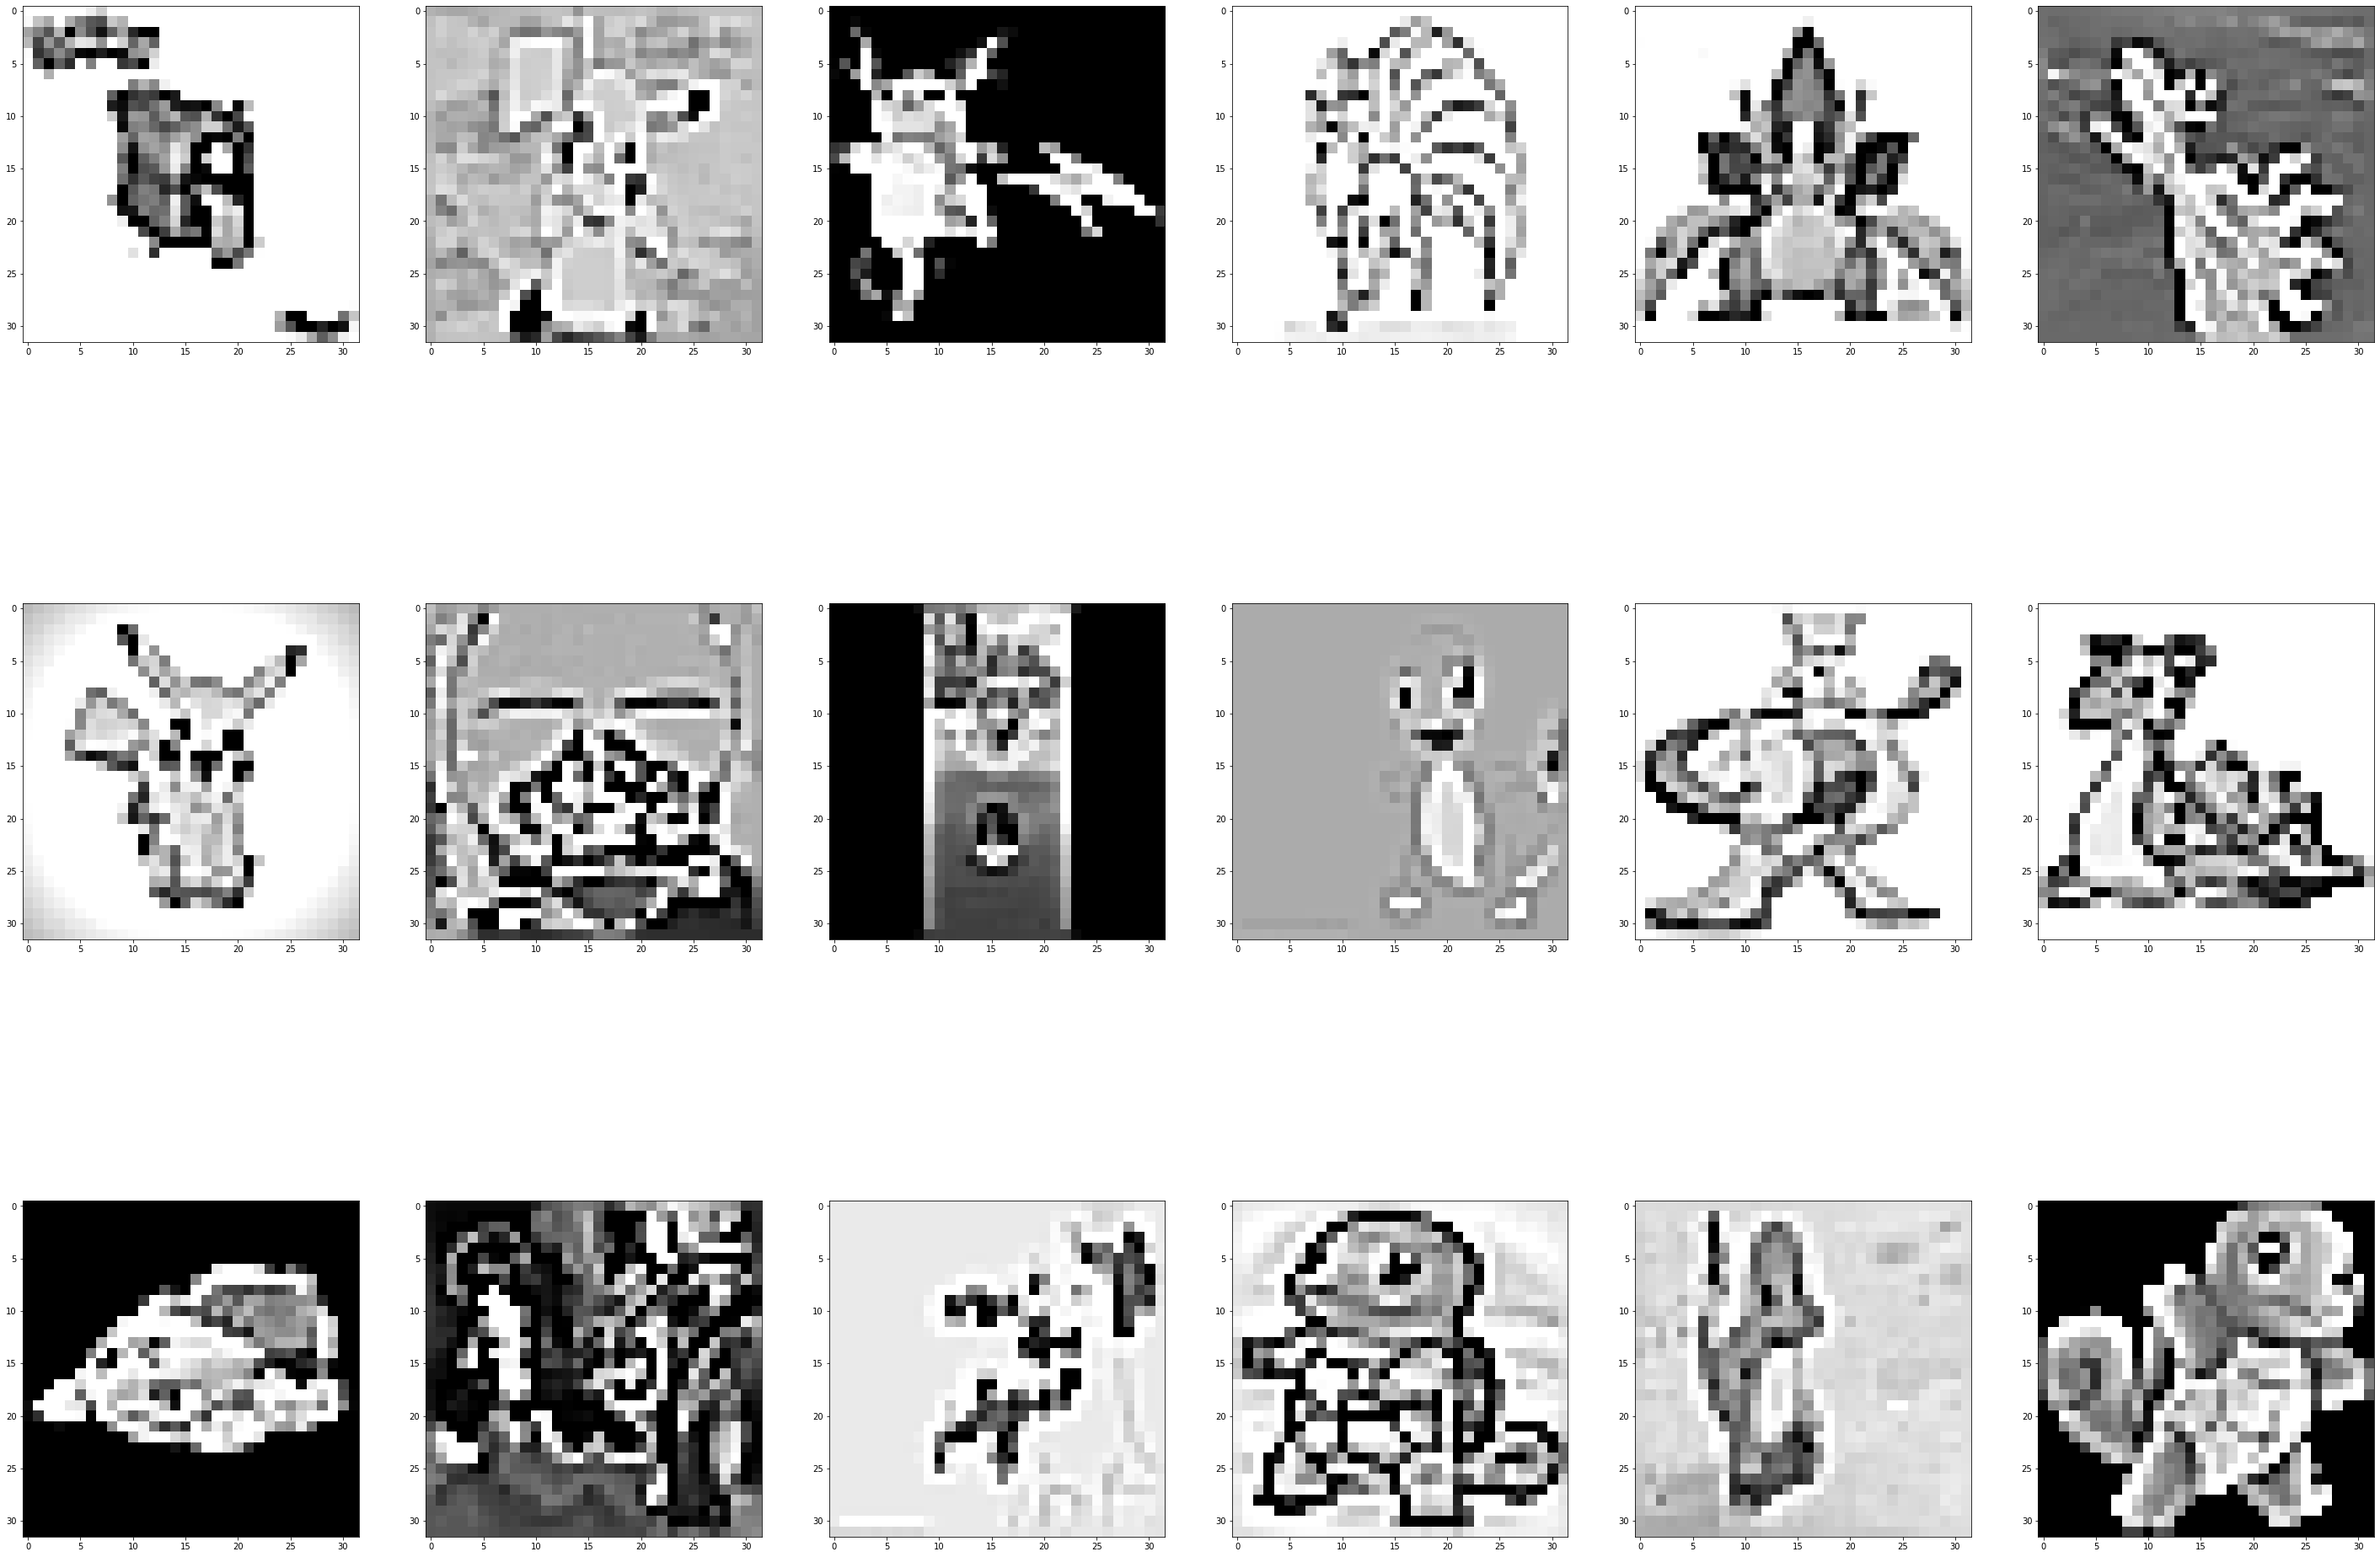

Training classifiers with filter: Edge Enhance
	 Using Classifier: Nearest Neighbor
		 Accuracy: 0.27703180 (+/- 0.03250883)
		 F1-Score: 0.26449967 (+/- 0.03362835)
		 Time it took to train: 14.341249942779541
	 Using Classifier: SVM
		 Accuracy: 0.43180212 (+/- 0.03647629)
		 F1-Score: 0.41389277 (+/- 0.03477160)
		 Time it took to train: 73.83467864990234
	 Using Classifier: RBF SVM
		 Accuracy: 0.26360424 (+/- 0.01816955)
		 F1-Score: 0.25575840 (+/- 0.01620653)
		 Time it took to train: 102.52802658081055
	 Using Classifier: Decision Tree
		 Accuracy: 0.21166078 (+/- 0.01845930)
		 F1-Score: 0.18384634 (+/- 0.02042635)
		 Time it took to train: 4.340123891830444
	 Using Classifier: Random Forest
		 Accuracy: 0.24699647 (+/- 0.01683181)
		 F1-Score: 0.18585548 (+/- 0.02544173)
		 Time it took to train: 1.9437878131866455
	 Using Classifier: AdaBoost
		 Accuracy: 0.18445230 (+/- 0.01411660)
		 F1-Score: 0.17418233 (+/- 0.01605801)
		 Time it took to train: 44.49887013435364
	 Using 

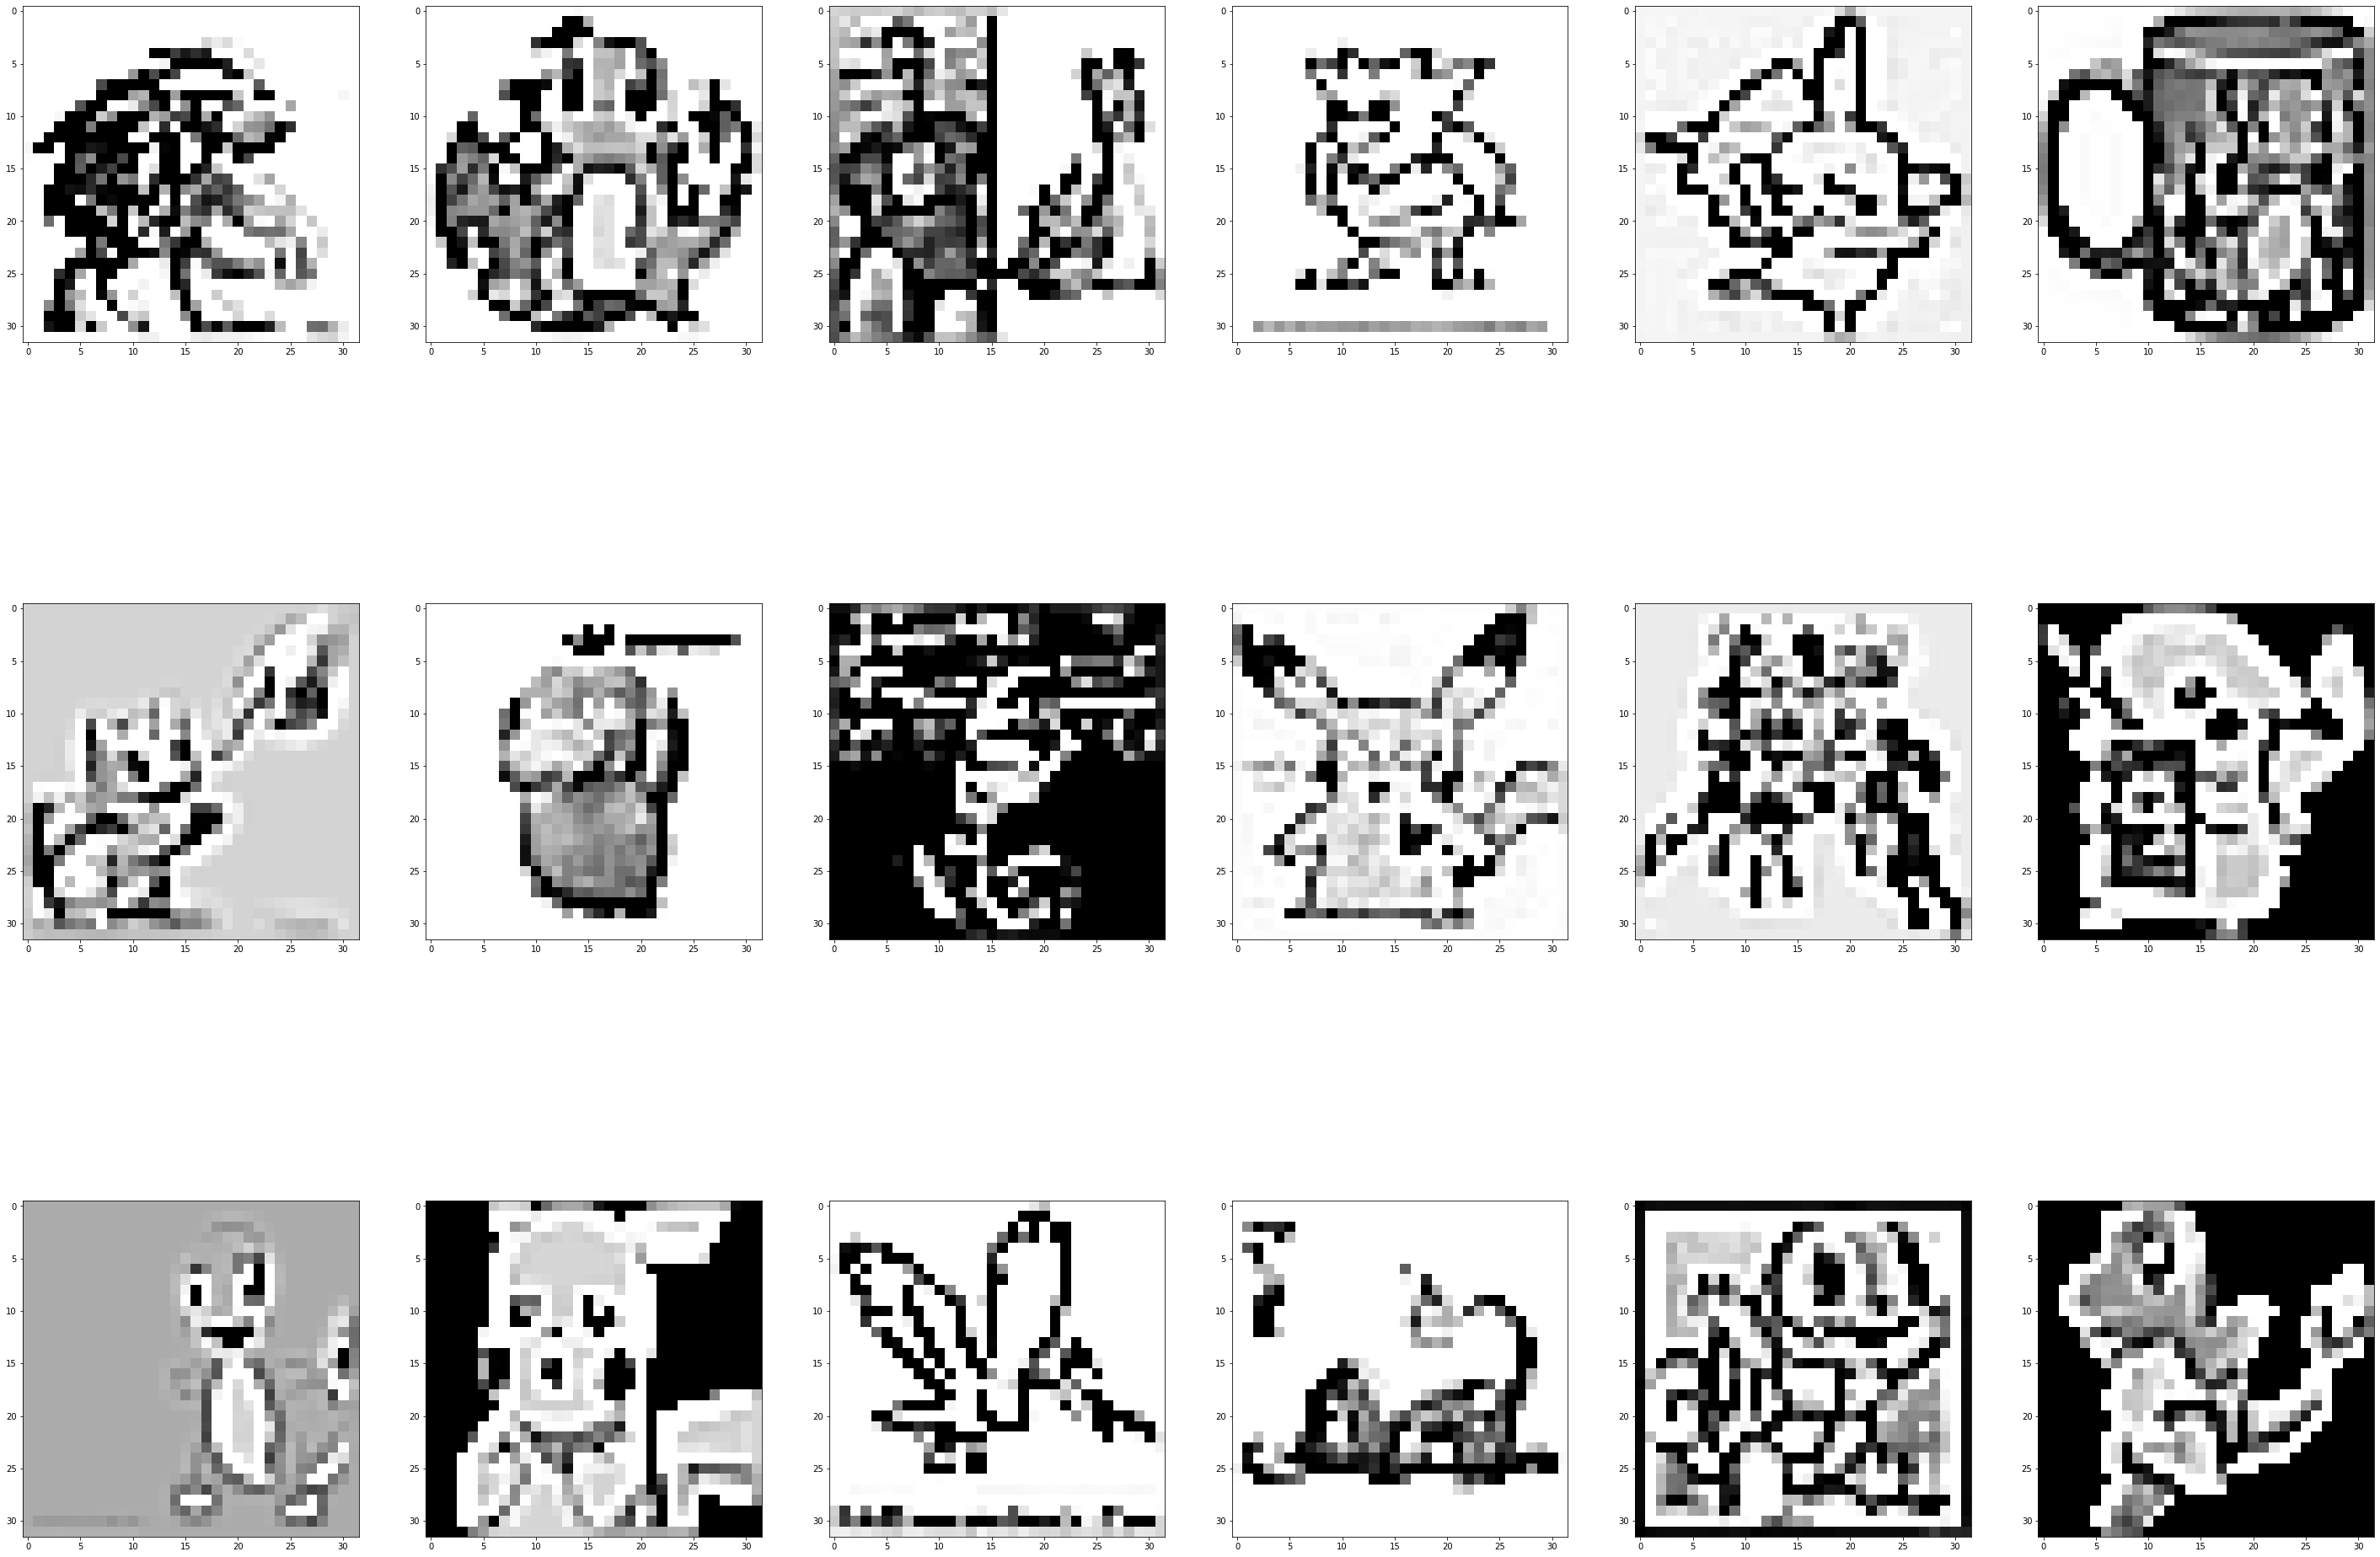

Training classifiers with filter: Edge Enhance More
	 Using Classifier: Nearest Neighbor
		 Accuracy: 0.28480565 (+/- 0.03780093)
		 F1-Score: 0.27308826 (+/- 0.03963570)
		 Time it took to train: 14.631040573120117
	 Using Classifier: SVM
		 Accuracy: 0.43215548 (+/- 0.02668020)
		 F1-Score: 0.41402472 (+/- 0.02695257)
		 Time it took to train: 76.91459703445435
	 Using Classifier: RBF SVM
		 Accuracy: 0.26360424 (+/- 0.01816955)
		 F1-Score: 0.25575840 (+/- 0.01620653)
		 Time it took to train: 103.40314507484436
	 Using Classifier: Decision Tree
		 Accuracy: 0.21378092 (+/- 0.01904525)
		 F1-Score: 0.18284921 (+/- 0.02139046)
		 Time it took to train: 4.0284998416900635
	 Using Classifier: Random Forest
		 Accuracy: 0.23215548 (+/- 0.02024029)
		 F1-Score: 0.17728090 (+/- 0.01349097)
		 Time it took to train: 1.8819704055786133
	 Using Classifier: AdaBoost
		 Accuracy: 0.16819788 (+/- 0.01864439)
		 F1-Score: 0.16289529 (+/- 0.01713349)
		 Time it took to train: 42.36739683151245
	 

In [7]:
%matplotlib inline

results = []
for image_filter in filters:
    print(f'============== Using Filter {image_filter} ================')
    scores = get_scores_for_classifiers(image_filter)
    results.append((image_filter[1], scores))

Here the above results get grouped by classifier instead of filter and get saved in a csv file.

In [8]:
for classifier in classifiers:
    classifier_results = []
    for result in results:
        image_filter = result[0]
        for clf_res in result[1]:
            if clf_res[0] == classifier[1]:
                classifier_results.append([image_filter] + clf_res[1:(len(clf_res))])
    dataframe_data = np.array(classifier_results)
    df = pd.DataFrame(dataframe_data, columns=['filter', "f1 score", "f1 score standard deviation", 'accuracy', 'accuracy standard deviation', 'time to train'])
    df.to_csv(f'csv/{classifier[1]}.csv', index=False)

This function plots the accuracy and f1-score with the standard deviation as error for all filters given the specified classifier. It also saves the plot as a png file.

In [29]:
def generate_plot(clf_name):
    plt.rcParams.update({
        'legend.fontsize': 20,
        'axes.labelsize': 20,
        'axes.titlesize': 20,
        'xtick.labelsize':20,
        'ytick.labelsize': 20
    })
    plt.figure()
    data = pd.read_csv(f'csv/{clf_name}.csv')
    axes = data[['f1 score', 'accuracy', 'filter']].plot(
        kind="bar", 
        x='filter',
        yerr = data[['f1 score standard deviation', 'accuracy standard deviation']].values.T,
        figsize=(15,10),
        subplots=True,
        title=clf_name,
        legend=False,
    )
    axes[0].set_ylabel('f1 score')
    axes[1].set_ylabel('accuracy')
    plt.tight_layout()
    plt.savefig(f'graphs/{clf_name}.png', pad_inches=0)


Here the above plot gets generated for every classifier.

<Figure size 432x288 with 0 Axes>

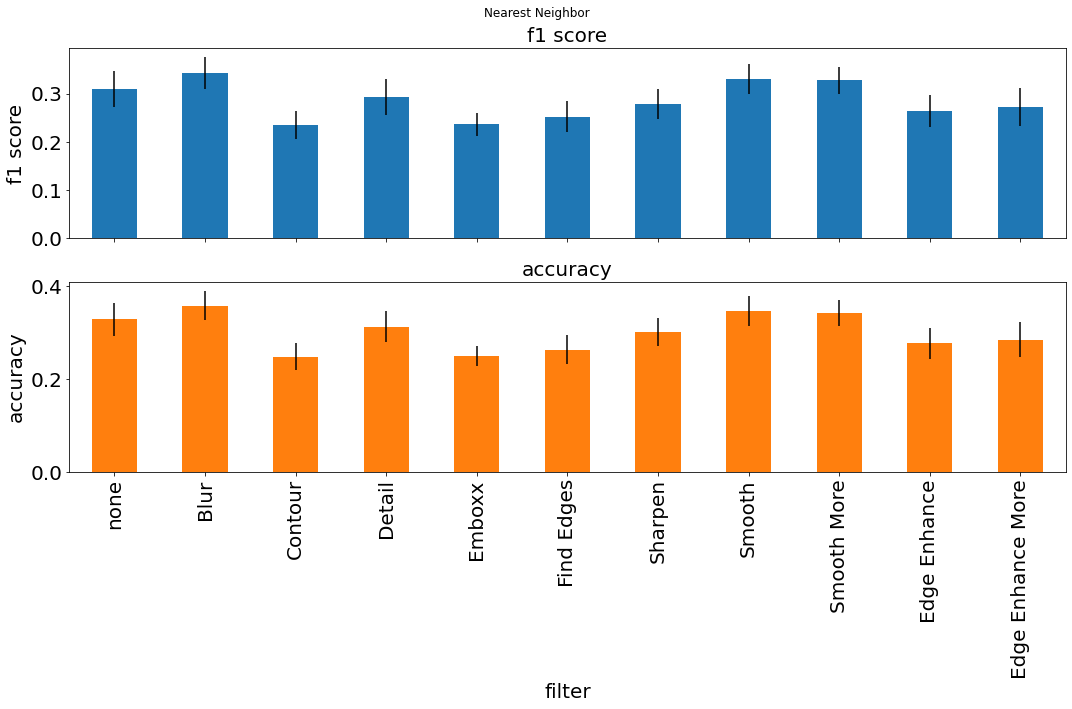

<Figure size 432x288 with 0 Axes>

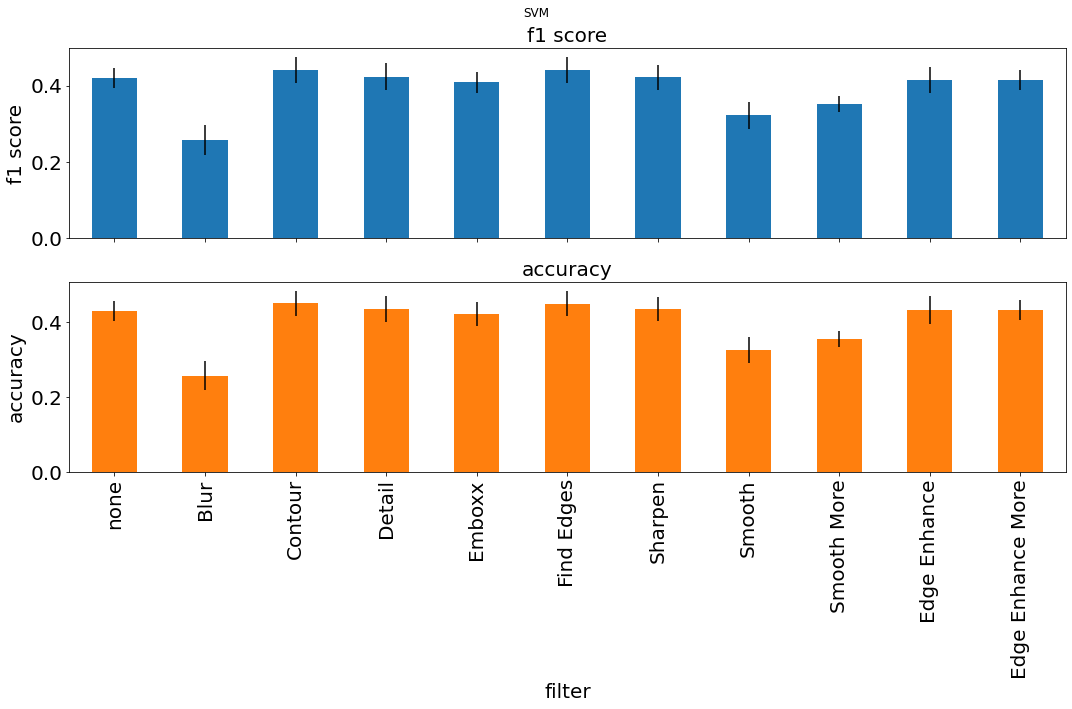

<Figure size 432x288 with 0 Axes>

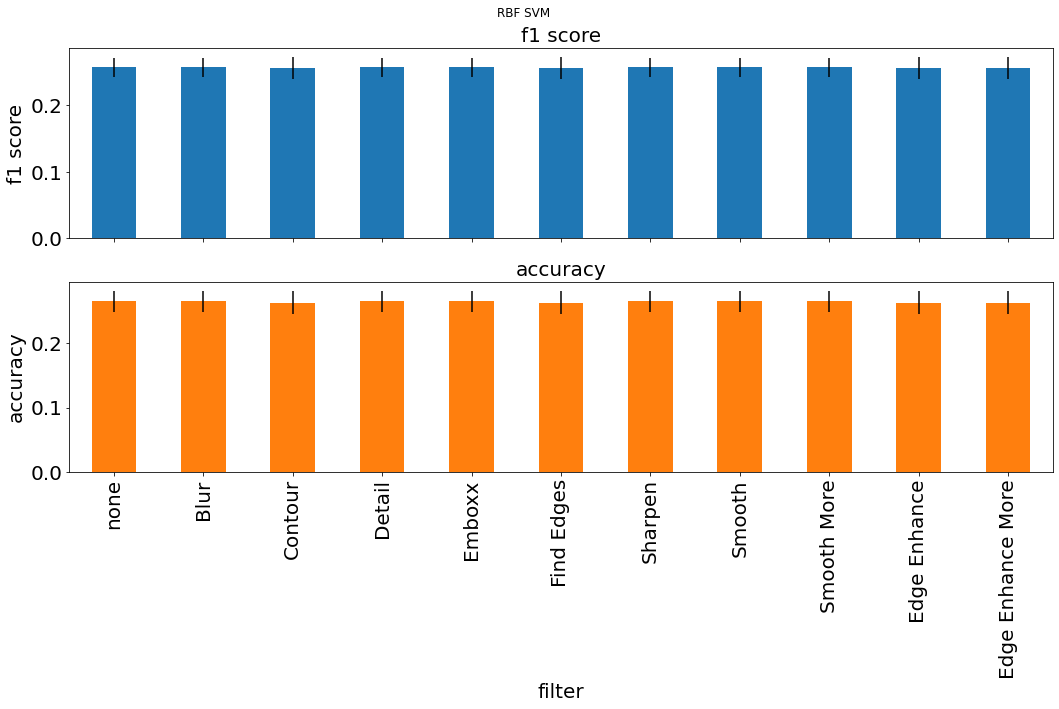

<Figure size 432x288 with 0 Axes>

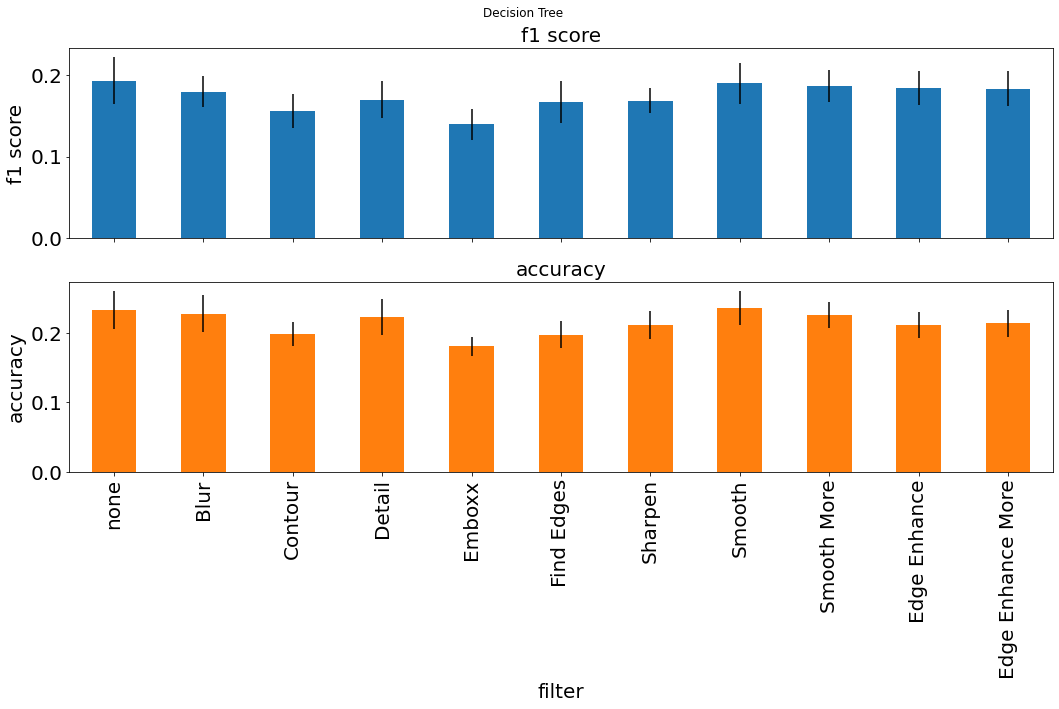

<Figure size 432x288 with 0 Axes>

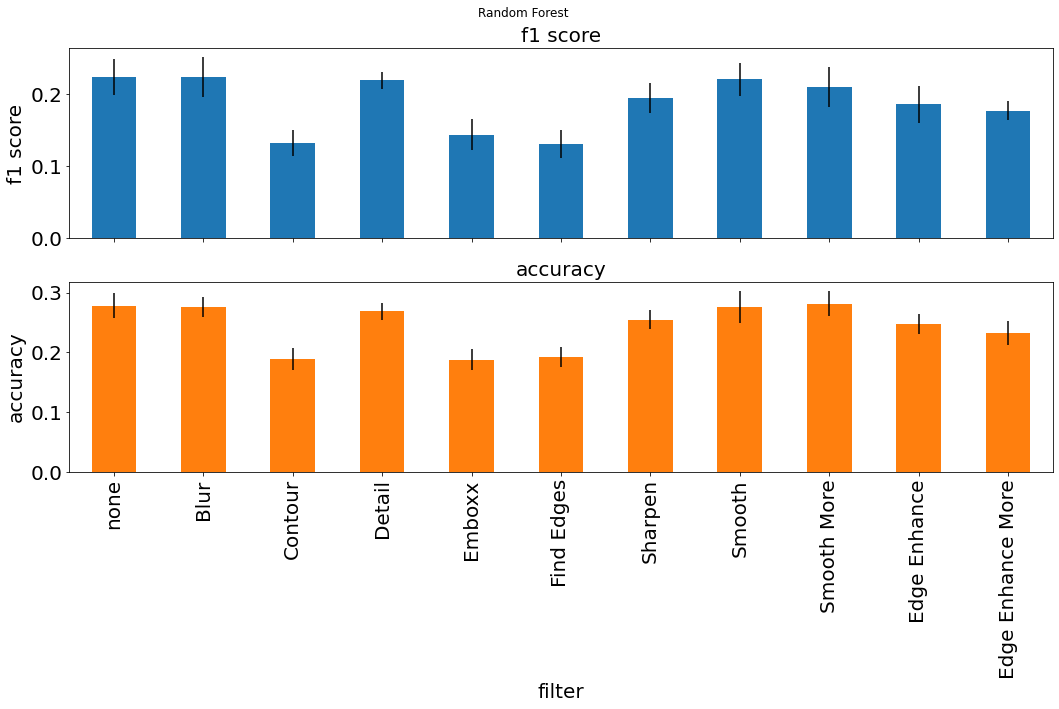

<Figure size 432x288 with 0 Axes>

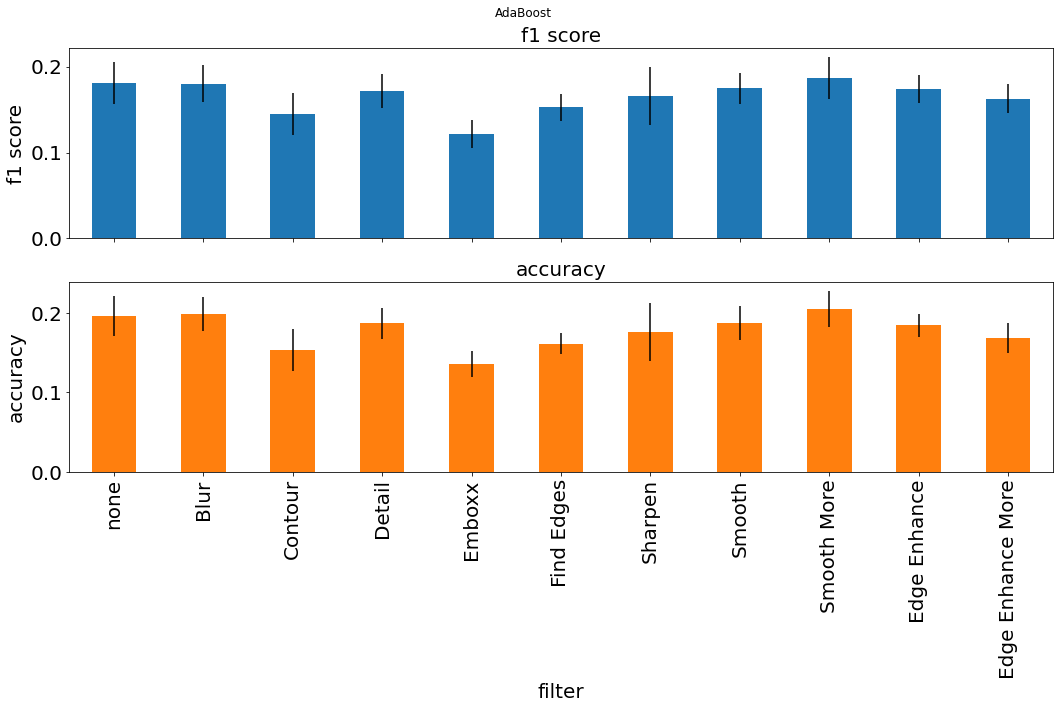

<Figure size 432x288 with 0 Axes>

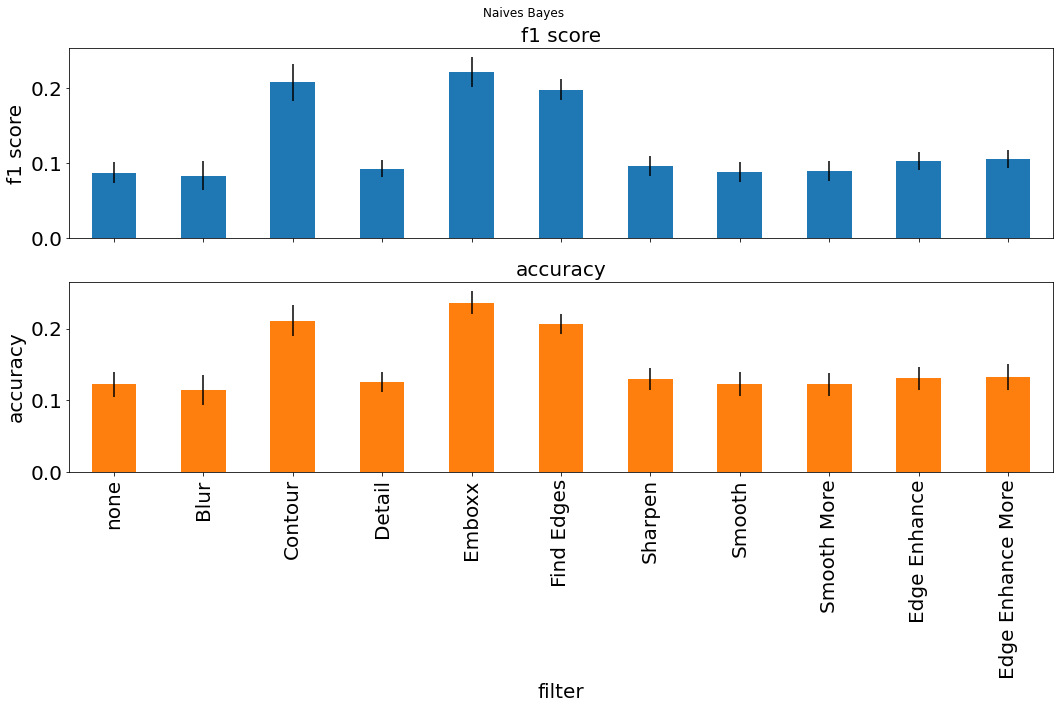

<Figure size 432x288 with 0 Axes>

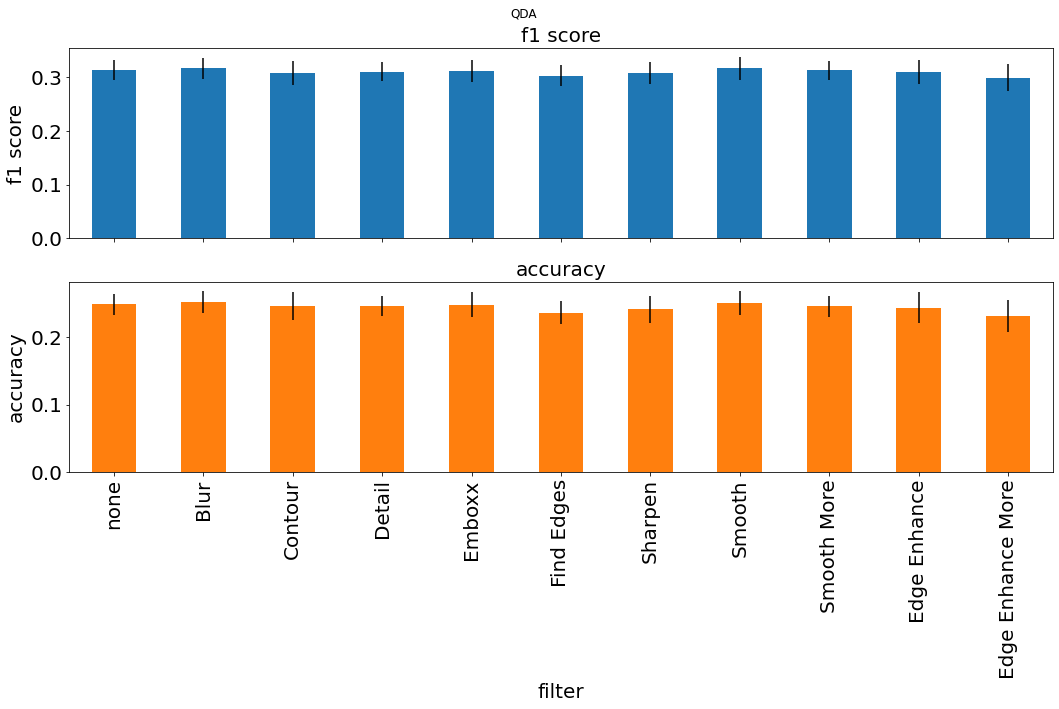

<Figure size 432x288 with 0 Axes>

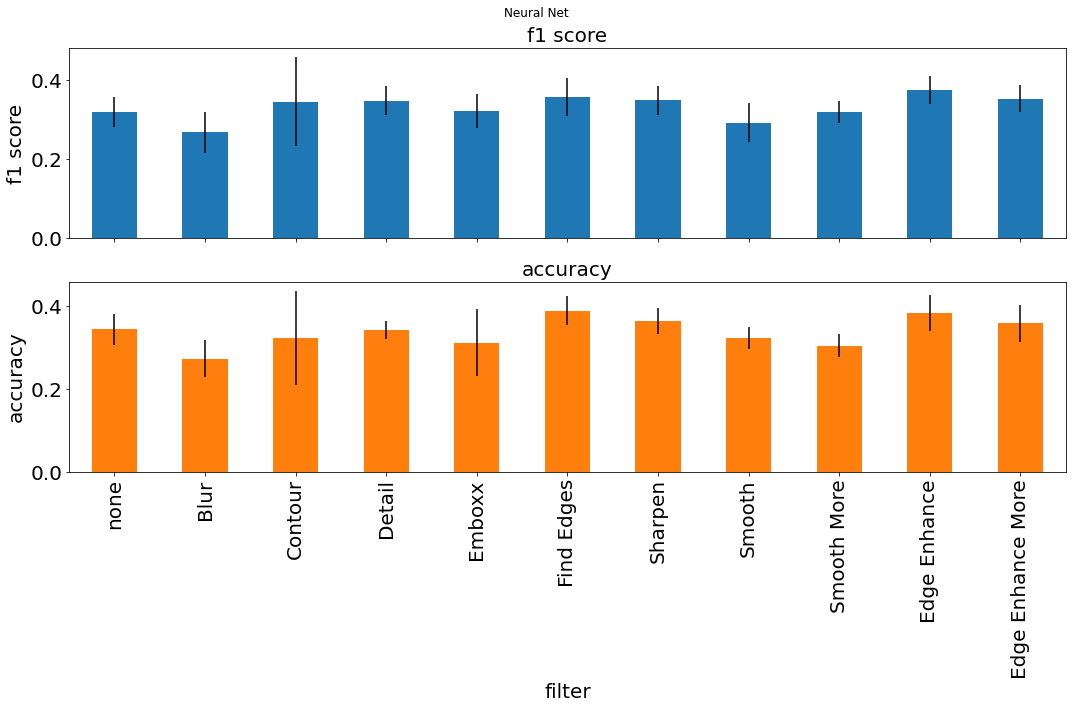

<Figure size 432x288 with 0 Axes>

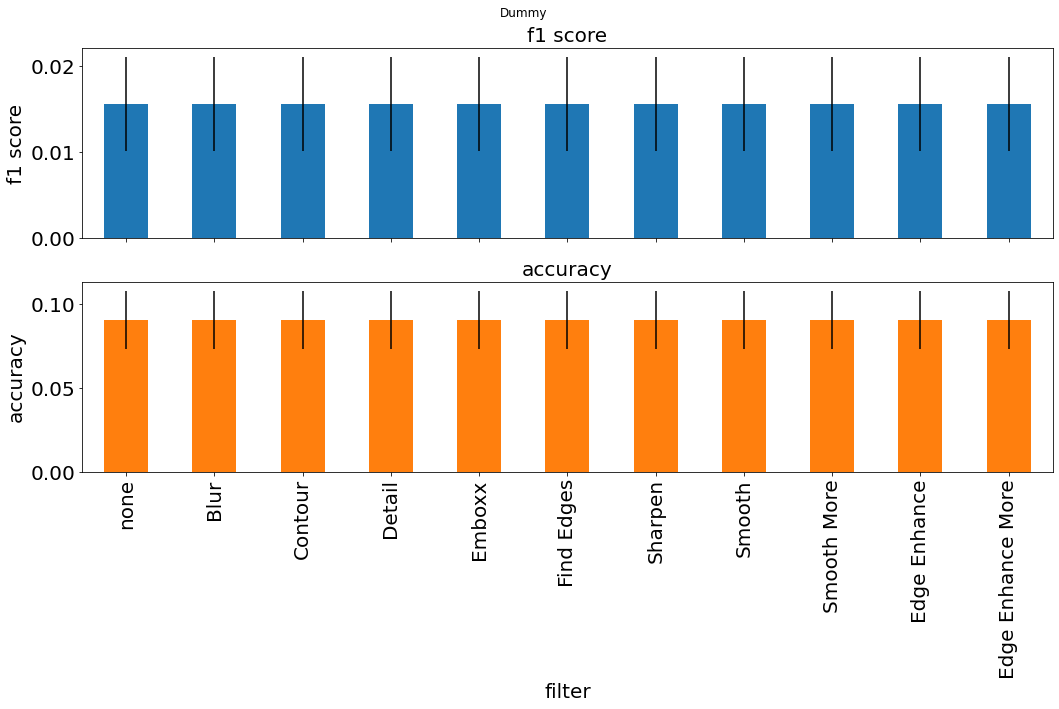

In [30]:
for clf in classifiers:
    generate_plot(clf[1])

This code snippet prints out the results for a given classifier. The Output can be copy&pasted into word and converted to a table (tabs are seperators)

In [27]:
clf = "QDA"
print('Filter\tF1-Score\tAccuracy')
data = pd.read_csv(f'csv/{clf}.csv')
for index, row in data.iterrows():
    f = row['filter']
    f1 = "%0.4f (± %0.4f)" % (row['f1 score'], row['f1 score standard deviation'])
    acc = "%0.4f (± %0.4f)" % (row['accuracy'], row['accuracy standard deviation'])
    print(f'{f}\t{f1}\t{acc}')

Filter	F1-Score	Accuracy
none	0.3137 (± 0.0194)	0.2491 (± 0.0157)
Blur	0.3168 (± 0.0202)	0.2527 (± 0.0157)
Contour	0.3081 (± 0.0226)	0.2466 (± 0.0208)
Detail	0.3106 (± 0.0179)	0.2463 (± 0.0148)
Emboxx	0.3114 (± 0.0201)	0.2488 (± 0.0181)
Find Edges	0.3030 (± 0.0192)	0.2367 (± 0.0172)
Sharpen	0.3085 (± 0.0208)	0.2420 (± 0.0198)
Smooth	0.3168 (± 0.0207)	0.2516 (± 0.0177)
Smooth More	0.3132 (± 0.0173)	0.2463 (± 0.0160)
Edge Enhance	0.3100 (± 0.0217)	0.2442 (± 0.0228)
Edge Enhance More	0.2998 (± 0.0250)	0.2322 (± 0.0238)


This snippet checks wheter some filter is better or worse than no filter with the given standard deviation. 

In [10]:
for clf in classifiers:
    data = pd.read_csv(f'csv/{clf[1]}.csv')
    no_filter = data.iloc[0]
    
    accuracy_top = no_filter['accuracy'] + no_filter['accuracy standard deviation']
    accuracy_bottom = no_filter['accuracy'] - no_filter['accuracy standard deviation']
    f1_top = no_filter['f1 score'] + no_filter['f1 score standard deviation']
    f1_bottom = no_filter['f1 score'] - no_filter['f1 score standard deviation']
    
    for index, row in data.iterrows():
        if float(row['accuracy']) + float(row['accuracy standard deviation']) < accuracy_bottom:
            print(f'The accuarcy of the classifier {clf[1]} of the filter {row["filter"]} is smaller than with no filter')
        elif float(row['accuracy']) - float(row['accuracy standard deviation']) > accuracy_top:
            print(f'The accuarcy of the classifier {clf[1]} of the filter {row["filter"]} is bigger than with no filter')
            
        if float(row['f1 score']) + float(row['f1 score standard deviation']) < f1_bottom:
            print(f'The f1-score of the classifier {clf[1]} of the filter {row["filter"]} is smaller than with no filter')
        elif float(row['f1 score']) - float(row['f1 score standard deviation']) > f1_top:
            print(f'The f1-score of the classifier {clf[1]} of the filter {row["filter"]} is bigger than with no filter')

The accuarcy of the classifier Nearest Neighbor of the filter Contour is smaller than with no filter
The f1-score of the classifier Nearest Neighbor of the filter Contour is smaller than with no filter
The accuarcy of the classifier Nearest Neighbor of the filter Emboxx is smaller than with no filter
The f1-score of the classifier Nearest Neighbor of the filter Emboxx is smaller than with no filter
The accuarcy of the classifier SVM of the filter Blur is smaller than with no filter
The f1-score of the classifier SVM of the filter Blur is smaller than with no filter
The accuarcy of the classifier SVM of the filter Smooth is smaller than with no filter
The f1-score of the classifier SVM of the filter Smooth is smaller than with no filter
The accuarcy of the classifier SVM of the filter Smooth More is smaller than with no filter
The f1-score of the classifier SVM of the filter Smooth More is smaller than with no filter
The accuarcy of the classifier Decision Tree of the filter Emboxx is s